CLASIFICACIÓN COMPLETA DE SISTEMAS BINARIOS
Incluye: Detached, Contact, Semi-Detached, CVs, WD, SD

📊 ESTADÍSTICAS BÁSICAS:
  • Amplitud total: 0.388 mag
  • Magnitud media: -0.005 mag
  • RMS: 0.03500 mag
  • MAD: 0.01030 mag (robust)
  • N puntos: 1646
  • Duración: 0.1800 días

🎯 ANÁLISIS DE PERIODO:
  • Período principal: 0.024686 días
  • Método: Lomb-Scargle
  • Horas: 0.59 h, Minutos: 36 min
  • Otros períodos encontrados: ['0.0247', '0.0108', '0.2295']

🌑 DETECCIÓN DE ECLIPSES:
  • Eclipses encontrados: 5
  • Razón profundidades (d2/d1): 0.414
  • Separación de fases: 0.401
  • Diferencia profundidades: 0.021 mag

📐 ANÁLISIS DE FORMA:
  • Asimetría (skew): 0.487
  • Curtosis: 0.866
  • Amplitud fuera eclipses: 0.0255 mag

🔍 DETECCIÓN DE EFECTOS ESPECIALES:
  • ENANA_BLANCA: DETECTADO

🎯 CLASIFICACIÓN FINAL

TIPO PRINCIPAL: DETACHED
SUBTIPO: Excéntrica
CONFIANZA: MEDIA

📋 PARÁMETROS CLAVE:
  • periodo_dias: 0.024686
  • periodo_horas: 0.59
  • amplitud_mag: 0.388
  • n_eclipses:

NameError: name 'classificacion' is not defined

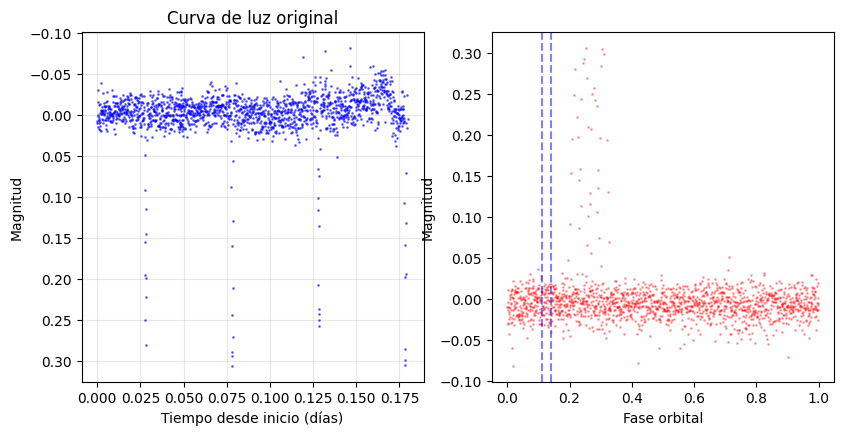

In [2]:
import numpy as np
from scipy import signal, stats, optimize
from astropy.timeseries import LombScargle
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import warnings
warnings.filterwarnings('ignore')

# ============================================
# ALGORITMO COMPLETO DE CLASIFICACIÓN DE BINARIAS
# Incluye todos los tipos: Detached, Contact, Semi-Detached,
# Cataclísmicas (CV), con Enanas Blancas (WD), etc.
# ============================================

def clasificacion_completa_binarias(times, mags, errors=None):
    """
    CLASIFICACIÓN COMPLETA DE SISTEMAS BINARIOS
    Usando solo curva de luz o datos mínimos
    
    Retorna: tipo, subtipo, parámetros clave y evidencias
    """
    
    print("="*70)
    print("CLASIFICACIÓN COMPLETA DE SISTEMAS BINARIOS")
    print("Incluye: Detached, Contact, Semi-Detached, CVs, WD, SD")
    print("="*70)
    
    # ============================================
    # 1. PREPROCESAMIENTO Y ESTADÍSTICAS BÁSICAS
    # ============================================
    
    if errors is None:
        errors = np.full_like(mags, np.std(mags)/10)
    
    times = np.array(times)
    mags = np.array(mags)
    
    # Estadísticas básicas
    amplitude = np.max(mags) - np.min(mags)
    median_mag = np.median(mags)
    rms = np.std(mags)
    mad = stats.median_abs_deviation(mags)
    
    print(f"\n📊 ESTADÍSTICAS BÁSICAS:")
    print(f"  • Amplitud total: {amplitude:.3f} mag")
    print(f"  • Magnitud media: {median_mag:.3f} mag")
    print(f"  • RMS: {rms:.5f} mag")
    print(f"  • MAD: {mad:.5f} mag (robust)")
    print(f"  • N puntos: {len(times)}")
    print(f"  • Duración: {times[-1]-times[0]:.4f} días")
    
    # ============================================
    # 2. ANÁLISIS DE PERIODO (MÚLTIPLES MÉTODOS)
    # ============================================
    
    def encontrar_periodo_robusto(t, m):
        """Encontrar período usando múltiples métodos"""
        
        periodos = []
        metodos = []
        
        # Método 1: Lomb-Scargle (frecuencia)
        try:
            ls = LombScargle(t, m)
            freq, power = ls.autopower(minimum_frequency=0.5, 
                                      maximum_frequency=100)
            if len(freq) > 0:
                best_freq = freq[np.argmax(power)]
                P_ls = 1.0 / best_freq
                periodos.append(P_ls)
                metodos.append('Lomb-Scargle')
        except:
            pass
        
        # Método 2: Autocorrelación
        try:
            m_norm = m - np.mean(m)
            corr = np.correlate(m_norm, m_norm, mode='full')
            corr = corr[len(corr)//2:]
            
            # Encontrar picos en autocorrelación
            peaks, _ = signal.find_peaks(corr, distance=len(t)*0.05)
            if len(peaks) > 1:
                P_autocorr = np.mean(np.diff(t[peaks[:min(5, len(peaks))]]))
                periodos.append(P_autocorr)
                metodos.append('Autocorrelación')
        except:
            pass
        
        # Método 3: String Length (Lafler-Kinman)
        try:
            def string_length(P_test, t_fold, m_fold):
                sort_idx = np.argsort(t_fold)
                L = np.sum(np.sqrt(np.diff(t_fold[sort_idx])**2 + 
                                  np.diff(m_fold[sort_idx])**2))
                return L
            
            # Buscar en rango razonable
            P_tests = np.linspace(0.05, 10, 500)
            lengths = []
            for P in P_tests:
                t_fold = t % P
                L = string_length(P, t_fold, m)
                lengths.append(L)
            
            P_sl = P_tests[np.argmin(lengths)]
            periodos.append(P_sl)
            metodos.append('String-Length')
        except:
            pass
        
        # Elegir mejor período
        if periodos:
            # Usar mediana de los métodos
            P_final = np.median(periodos)
            idx_best = np.argmin(np.abs(np.array(periodos) - P_final))
            metodo_best = metodos[idx_best]
            return P_final, metodo_best, periodos
        else:
            return None, None, []
    
    periodo, metodo_periodo, todos_periodos = encontrar_periodo_robusto(times, mags)
    
    print(f"\n🎯 ANÁLISIS DE PERIODO:")
    if periodo:
        print(f"  • Período principal: {periodo:.6f} días")
        print(f"  • Método: {metodo_periodo}")
        print(f"  • Horas: {periodo*24:.2f} h, Minutos: {periodo*24*60:.0f} min")
        
        if len(todos_periodos) > 1:
            print(f"  • Otros períodos encontrados: {[f'{p:.4f}' for p in todos_periodos]}")
    else:
        print("  ⚠️ No se pudo determinar período automáticamente")
        periodo = 1.0  # Valor por defecto
    
    # ============================================
    # 3. DETECCIÓN Y CARACTERIZACIÓN DE ECLIPSES
    # ============================================
    
    def caracterizar_eclipses(t, m, P):
        """Caracterizar eclipses en la curva de luz"""
        
        # Plegar datos
        t_folded = t % P
        phase = t_folded / P
        
        # Suavizar para detección
        window = min(51, len(m)//10 * 2 + 1)
        if window % 2 == 0:
            window += 1
        
        try:
            m_smooth = signal.savgol_filter(m, window, 3)
        except:
            m_smooth = m
        
        # Encontrar mínimos (eclipses)
        min_indices, min_props = signal.find_peaks(
            -m_smooth,
            prominence=amplitude*0.05,  # Mínimo 5% de amplitud
            distance=len(t)*0.05,
            width=3
        )
        
        # Encontrar máximos
        max_indices, max_props = signal.find_peaks(
            m_smooth,
            prominence=amplitude*0.03,
            distance=len(t)*0.05
        )
        
        resultados = {
            'n_eclipses': len(min_indices),
            'min_indices': min_indices,
            'min_props': min_props,
            'max_indices': max_indices,
            'phase': phase,
            'm_smooth': m_smooth
        }
        
        # Si hay eclipses, caracterizarlos
        if len(min_indices) >= 2:
            # Profundidades relativas al máximo
            depths = m[min_indices]
            sorted_idx = np.argsort(depths)  # Más profundo primero
            
            # Eclipse primario (más profundo)
            primary_idx = min_indices[sorted_idx[0]]
            primary_depth = m[primary_idx]
            primary_phase = phase[primary_idx]
            
            # Eclipse secundario
            secondary_idx = min_indices[sorted_idx[1]] if len(sorted_idx) > 1 else None
            if secondary_idx is not None:
                secondary_depth = m[secondary_idx]
                secondary_phase = phase[secondary_idx]
                
                # Calcular razones
                depth_ratio = abs((secondary_depth - median_mag) / (primary_depth - median_mag))
                phase_sep = min(abs(secondary_phase - primary_phase), 
                              1 - abs(secondary_phase - primary_phase))
                
                resultados.update({
                    'primary_depth': primary_depth,
                    'primary_phase': primary_phase,
                    'secondary_depth': secondary_depth,
                    'secondary_phase': secondary_phase,
                    'depth_ratio': depth_ratio,
                    'phase_separation': phase_sep,
                    'depth_difference': abs(primary_depth - secondary_depth)
                })
        
        return resultados
    
    eclipse_info = caracterizar_eclipses(times, mags, periodo)
    
    print(f"\n🌑 DETECCIÓN DE ECLIPSES:")
    print(f"  • Eclipses encontrados: {eclipse_info['n_eclipses']}")
    
    if eclipse_info['n_eclipses'] >= 2:
        print(f"  • Razón profundidades (d2/d1): {eclipse_info.get('depth_ratio', 0):.3f}")
        print(f"  • Separación de fases: {eclipse_info.get('phase_separation', 0):.3f}")
        print(f"  • Diferencia profundidades: {eclipse_info.get('depth_difference', 0):.3f} mag")
    
    # ============================================
    # 4. ANÁLISIS DE FORMA DE LA CURVA
    # ============================================
    
    def analizar_forma_curva(t, m, P, eclipse_info):
        """Analizar forma de la curva para clasificación"""
        
        # Plegar y promediar en fases
        t_folded = t % P
        phase = t_folded / P
        
        # Crear curva de luz promedio (fase-binned)
        n_bins = 100
        phase_bins = np.linspace(0, 1, n_bins+1)
        bin_centers = (phase_bins[:-1] + phase_bins[1:]) / 2
        bin_means = np.zeros(n_bins)
        bin_stds = np.zeros(n_bins)
        
        for i in range(n_bins):
            mask = (phase >= phase_bins[i]) & (phase < phase_bins[i+1])
            if np.sum(mask) > 0:
                bin_means[i] = np.median(m[mask])
                bin_stds[i] = np.std(m[mask])
            else:
                bin_means[i] = np.nan
        
        # Eliminar NaNs
        valid = ~np.isnan(bin_means)
        if np.sum(valid) < 10:
            return {}
        
        bin_centers = bin_centers[valid]
        bin_means = bin_means[valid]
        
        # Calcular métricas de forma
        # 1. Asimetría fuera de eclipses
        outside_eclipse = bin_means.copy()
        if eclipse_info['n_eclipses'] >= 2:
            # Enmascarar regiones de eclipse
            primary_phase = eclipse_info.get('primary_phase', 0)
            secondary_phase = eclipse_info.get('secondary_phase', 0.5)
            eclipse_width = 0.1  # Ancho de fase asumido
            
            for i, phase_val in enumerate(bin_centers):
                dist_primary = min(abs(phase_val - primary_phase), 
                                 1 - abs(phase_val - primary_phase))
                dist_secondary = min(abs(phase_val - secondary_phase), 
                                   1 - abs(phase_val - secondary_phase))
                
                if dist_primary < eclipse_width or dist_secondary < eclipse_width:
                    outside_eclipse[i] = np.nan
        
        outside_eclipse = outside_eclipse[~np.isnan(outside_eclipse)]
        
        if len(outside_eclipse) > 5:
            skew = stats.skew(outside_eclipse)
            kurt = stats.kurtosis(outside_eclipse)
        else:
            skew = 0
            kurt = 0
        
        # 2. Variación fuera de eclipses (efecto ellipsoidal)
        outside_amplitude = np.max(outside_eclipse) - np.min(outside_eclipse) if len(outside_eclipse) > 5 else 0
        
        # 3. Pendiente entre eclipses
        if eclipse_info['n_eclipses'] >= 2:
            primary_phase = eclipse_info.get('primary_phase', 0)
            secondary_phase = eclipse_info.get('secondary_phase', 0.5)
            
            # Encontrar puntos entre eclipses
            phase_mid = (primary_phase + secondary_phase) / 2
            if phase_mid > 1:
                phase_mid -= 1
            
            # Ajuste lineal alrededor del punto medio
            mask_mid = (phase >= phase_mid - 0.1) & (phase <= phase_mid + 0.1)
            if np.sum(mask_mid) > 5:
                slope, intercept = np.polyfit(phase[mask_mid], m[mask_mid], 1)
            else:
                slope = 0
        else:
            slope = 0
        
        return {
            'skewness': skew,
            'kurtosis': kurt,
            'outside_amplitude': outside_amplitude,
            'slope_mid_phase': slope,
            'phase_binned': bin_centers,
            'mag_binned': bin_means
        }
    
    forma_info = analizar_forma_curva(times, mags, periodo, eclipse_info)
    
    print(f"\n📐 ANÁLISIS DE FORMA:")
    print(f"  • Asimetría (skew): {forma_info.get('skewness', 0):.3f}")
    print(f"  • Curtosis: {forma_info.get('kurtosis', 0):.3f}")
    print(f"  • Amplitud fuera eclipses: {forma_info.get('outside_amplitude', 0):.4f} mag")
    
    # ============================================
    # 5. DETECCIÓN DE EFECTOS ESPECIALES (WD, Discos, etc.)
    # ============================================
    
    def detectar_efectos_especiales(t, m, P, eclipse_info):
        """Detectar efectos que indican sistemas especiales"""
        
        efectos = {
            'pulsaciones': False,
            'manchas': False,
            'disco_acrecion': False,
            'enana_blanca': False,
            'flare': False,
            'ellipsoidal': False
        }
        
        evidencias = []
        
        # Plegar datos
        t_folded = t % P
        phase = t_folded / P
        
        # 1. Buscar pulsaciones (variación rápida)
        # Análisis de Fourier de residuos
        if len(m) > 100:
            # Crear modelo suave
            try:
                m_smooth = signal.savgol_filter(m, min(51, len(m)//10), 3)
                residuos = m - m_smooth
                
                # Buscar frecuencias altas
                ls_res = LombScargle(t, residuos)
                freq_res, power_res = ls.autopower(minimum_frequency=10, 
                                                  maximum_frequency=1000)
                
                # Umbral para detección
                threshold = np.median(power_res) + 3*np.std(power_res)
                n_peaks_altas = np.sum(power_res > threshold)
                
                if n_peaks_altas > 3:
                    efectos['pulsaciones'] = True
                    evidencias.append(f"Pulsaciones detectadas: {n_peaks_altas} picos > 3σ")
            except:
                pass
        
        # 2. Buscar variación ellipsoidal (variación sinusoidal)
        # Ajustar seno a la curva
        try:
            def sin_model(t, A, phi, offset):
                return A * np.sin(2*np.pi*t/P + phi) + offset
            
            popt, _ = optimize.curve_fit(sin_model, t, m, 
                                        p0=[amplitude/2, 0, median_mag])
            A_sin = abs(popt[0])
            
            # Si amplitud sinusoidal es > 30% amplitud total
            if A_sin > amplitude * 0.3 and eclipse_info['n_eclipses'] < 2:
                efectos['ellipsoidal'] = True
                evidencias.append(f"Fuerte variación ellipsoidal (A={A_sin:.3f} mag)")
        except:
            pass
        
        # 3. Indicadores de enana blanca / sistema compacto
        # - Período muy corto
        # - Eclipses muy profundos y simétricos
        # - Posible "hump" antes del eclipse (disco caliente)
        
        if periodo < 0.2:  # < 4.8 horas
            efectos['enana_blanca'] = True
            evidencias.append(f"Período ultracorto ({periodo*24:.1f}h) sugiere WD")
        
        if eclipse_info['n_eclipses'] >= 2:
            depth_ratio = eclipse_info.get('depth_ratio', 0)
            phase_sep = eclipse_info.get('phase_separation', 0)
            
            # Eclipses muy profundos y simétricos
            if amplitude > 1.0 and abs(depth_ratio - 1) < 0.2:
                efectos['disco_acrecion'] = True
                evidencias.append("Eclipses profundos simétricos sugieren disco")
            
            # "Hump" orbital (disco caliente)
            # Buscar asimetría antes/después del primario
            if eclipse_info.get('primary_phase', None) is not None:
                primary_phase = eclipse_info['primary_phase']
                pre_eclipse = (phase > primary_phase - 0.1) & (phase < primary_phase)
                post_eclipse = (phase > primary_phase) & (phase < primary_phase + 0.1)
                
                if np.sum(pre_eclipse) > 5 and np.sum(post_eclipse) > 5:
                    mag_pre = np.median(m[pre_eclipse])
                    mag_post = np.median(m[post_eclipse])
                    
                    if mag_pre - mag_post > 0.05:  # Hump antes del eclipse
                        efectos['disco_acrecion'] = True
                        evidencias.append(f"Hump orbital detectado (Δ={mag_pre-mag_post:.3f} mag)")
        
        return efectos, evidencias
    
    efectos, evidencias_efectos = detectar_efectos_especiales(times, mags, periodo, eclipse_info)
    
    print(f"\n🔍 DETECCIÓN DE EFECTOS ESPECIALES:")
    for efecto, activo in efectos.items():
        if activo:
            print(f"  • {efecto.upper()}: DETECTADO")
    
    # ============================================
    # 6. CLASIFICACIÓN POR ÁRBOL DE DECISIÓN
    # ============================================
    
    def clasificar_arbol_decision(P, eclipse_info, forma_info, efectos):
        """Árbol de decisión para clasificación completa"""
        
        n_eclipses = eclipse_info['n_eclipses']
        depth_ratio = eclipse_info.get('depth_ratio', 0)
        phase_sep = eclipse_info.get('phase_separation', 0.5)
        outside_amp = forma_info.get('outside_amplitude', 0)
        skew = forma_info.get('skewness', 0)
        
        clasificacion = {
            'tipo_principal': 'INDETERMINADO',
            'subtipo': '',
            'confianza': 'BAJA',
            'parametros_clave': {},
            'evidencias': []
        }
        
        # EVIDENCIAS RECOLECTADAS
        evidencias = []
        
        # ========== PASO 1: ¿TIENE ECLIPSES? ==========
        if n_eclipses == 0:
            # SIN ECLIPSES
            if efectos['ellipsoidal']:
                clasificacion['tipo_principal'] = 'ELLIPSOIDAL'
                clasificacion['subtipo'] = 'Binaria cercana sin eclipses'
                evidencias.append("Variación sinusoidal sin eclipses")
                
                if P < 0.5:
                    clasificacion['subtipo'] += ' (período corto)'
                    evidencias.append(f"Período corto: {P*24:.1f}h")
            else:
                clasificacion['tipo_principal'] = 'NO ECLIPSANTE'
                clasificacion['subtipo'] = 'Posible binaria espectroscópica'
                evidencias.append("Sin eclipses detectados")
        
        elif n_eclipses == 1:
            # UN SOLO ECLIPSE
            clasificacion['tipo_principal'] = 'ECLIPSANTE SIMPLE'
            evidencias.append("Solo un eclipse detectado")
            
            if P < 0.3:
                clasificacion['subtipo'] = 'Posible CV con eclipse único'
                evidencias.append(f"Período ultracorto: {P*24:.1f}h")
            else:
                clasificacion['subtipo'] = 'Binaria con eclipse parcial o excentricidad alta'
        
        else:
            # DOS O MÁS ECLIPSES
            # ========== PASO 2: CLASIFICAR POR PROFUNDIDAD ==========
            if depth_ratio > 0.8:
                # PROFUNDIDADES SIMILARES
                if P < 0.3:
                    clasificacion['tipo_principal'] = 'CONTACT'
                    clasificacion['subtipo'] = 'W Ursae Majoris (EW)'
                    evidencias.append(f"Profundidades similares (ratio={depth_ratio:.2f})")
                    evidencias.append(f"Período ultracorto: {P*24:.1f}h")
                    
                    if outside_amp > 0.1:
                        clasificacion['subtipo'] += ' con fuerte variación ellipsoidal'
                else:
                    clasificacion['tipo_principal'] = 'SEMI-DETACHED'
                    clasificacion['subtipo'] = 'Tipo β Lyrae (EB)'
                    evidencias.append("Profundidades similares, período moderado")
            
            elif depth_ratio > 0.3:
                # PROFUNDIDADES MODERADAMENTE DIFERENTES
                if abs(phase_sep - 0.5) > 0.05:
                    clasificacion['tipo_principal'] = 'DETACHED'
                    clasificacion['subtipo'] = 'Excéntrica'
                    evidencias.append(f"Separación fases no 0.5: {phase_sep:.2f}")
                else:
                    clasificacion['tipo_principal'] = 'SEMI-DETACHED'
                    clasificacion['subtipo'] = 'Tipo Algol (EA)'
                    evidencias.append(f"Razón profundidades: {depth_ratio:.2f}")
            
            else:
                # PROFUNDIDADES MUY DIFERENTES
                clasificacion['tipo_principal'] = 'DETACHED'
                clasificacion['subtipo'] = 'Tipo transit'
                evidencias.append(f"Razón profundidades muy baja: {depth_ratio:.2f}")
                
                if P < 0.5:
                    clasificacion['subtipo'] = 'Posible binaria con WD'
                    evidencias.append("Período corto con eclipses desiguales")
        
        # ========== PASO 3: APLICAR CORRECCIONES POR EFECTOS ESPECIALES ==========
        
        # SISTEMAS CON ENANA BLANCA (WD)
        if efectos['enana_blanca']:
            if clasificacion['tipo_principal'] == 'CONTACT' and P < 0.2:
                clasificacion['tipo_principal'] = 'CATACLÍSMICA'
                clasificacion['subtipo'] = 'Variable cataclísmica (CV)'
                evidencias.append("Período ultracorto típico de CVs")
            
            elif efectos['disco_acrecion']:
                clasificacion['tipo_principal'] = 'CATACLÍSMICA'
                if P < 0.2:
                    clasificacion['subtipo'] = 'Enana blanca con disco de acreción (DN)'
                else:
                    clasificacion['subtipo'] = 'Binaria con transferencia de masa'
                evidencias.extend(evidencias_efectos)
        
        # SISTEMAS CON DISCOS DE ACRECIÓN
        elif efectos['disco_acrecion']:
            if P < 0.5:
                clasificacion['tipo_principal'] = 'SEMI-DETACHED'
                clasificacion['subtipo'] = 'Con disco de acreción (Tipo Ser)'
                evidencias.append("Evidencias de disco de acreción")
        
        # PULSACIONES
        if efectos['pulsaciones']:
            clasificacion['subtipo'] += ' con pulsaciones'
            evidencias.append("Pulsaciones detectadas en residuos")
        
        # ========== PASO 4: ASIGNAR CONFIANZA ==========
        
        # Calcular confianza basada en evidencias
        n_evidencias = len(evidencias)
        if n_evidencias >= 3:
            clasificacion['confianza'] = 'ALTA'
        elif n_evidencias >= 1:
            clasificacion['confianza'] = 'MEDIA'
        
        clasificacion['evidencias'] = evidencias
        
        # Parámetros clave para reporte
        clasificacion['parametros_clave'] = {
            'periodo_dias': P,
            'periodo_horas': P * 24,
            'amplitud_mag': amplitude,
            'n_eclipses': n_eclipses,
            'depth_ratio': depth_ratio if n_eclipses >= 2 else None,
            'phase_separation': phase_sep if n_eclipses >= 2 else None
        }
        
        return clasificacion
    
    # Ejecutar clasificación
    clasificacion = clasificar_arbol_decision(periodo, eclipse_info, forma_info, efectos)
    
    # ============================================
    # 7. REPORTE FINAL
    # ============================================
    
    print("\n" + "="*70)
    print("🎯 CLASIFICACIÓN FINAL")
    print("="*70)
    
    print(f"\nTIPO PRINCIPAL: {clasificacion['tipo_principal']}")
    print(f"SUBTIPO: {clasificacion['subtipo']}")
    print(f"CONFIANZA: {clasificacion['confianza']}")
    
    print(f"\n📋 PARÁMETROS CLAVE:")
    params = clasificacion['parametros_clave']
    for key, val in params.items():
        if val is not None:
            if 'periodo' in key:
                if 'horas' in key:
                    print(f"  • {key}: {val:.2f}")
                else:
                    print(f"  • {key}: {val:.6f}")
            else:
                print(f"  • {key}: {val:.3f}")
    
    print(f"\n🔍 EVIDENCIAS ({len(clasificacion['evidencias'])}):")
    for i, ev in enumerate(clasificacion['evidencias'], 1):
        print(f"  {i}. {ev}")
    
    # ============================================
    # 8. RECOMENDACIONES ESPECÍFICAS POR TIPO
    # ============================================
    
    print(f"\n💡 RECOMENDACIONES PARA {clasificacion['tipo_principal']}:")
    
    recomendaciones = {
        'CONTACT': [
            "Obtener fotometría multibanda para temperaturas",
            "Buscar espectros para metalicidad",
            "Monitorear cambios de período (O-C diagram)"
        ],
        'SEMI-DETACHED': [
            "Espectroscopía para determinar donante/receptor",
            "Fotometría UV para disco de acreción",
            "Monitorear outbursts si es variable"
        ],
        'DETACHED': [
            "Velocidades radiales para masas absolutas",
            "Espectros para temperaturas efectivas",
            "Buscar excentricidad con tiempos de eclipses"
        ],
        'CATACLÍSMICA': [
            "⚠️ ALTA PRIORIDAD: Espectroscopía para confirmar WD",
            "Fotometría rápida para estudios de disco",
            "Observar en UV/X-ray si es posible",
            "Reportar a vsnet o similar"
        ],
        'ELLIPSOIDAL': [
            "Espectroscopía para confirmar binaria",
            "Fotometría de alta precisión",
            "Buscar posibles eclipses muy someros"
        ],
        'NO ECLIPSANTE': [
            "Espectroscopía para velocidades radiales",
            "Astrometría de precisión (GAIA)",
            "Buscar variación ellipsoidal con más datos"
        ]
    }
    
    tipo = clasificacion['tipo_principal']
    if tipo in recomendaciones:
        for i, rec in enumerate(recomendaciones[tipo], 1):
            print(f"  {i}. {rec}")
    else:
        print("  • Espectroscopía para clasificación definitiva")
        print("  • Más fotometría en diferentes bandas")
        print("  • Buscar en catálogos (VSX, SIMBAD, GAIA)")
    
    # ============================================
    # 9. GRÁFICOS DE DIAGNÓSTICO
    # ============================================
    
    def crear_graficos_diagnostico(t, m, P, clasificacion, eclipse_info, forma_info):
        """Crear gráficos de diagnóstico completos"""
        
        fig = plt.figure(figsize=(15, 10))
        
        # 1. Curva de luz original
        ax1 = plt.subplot(2, 3, 1)
        ax1.plot(t - t[0], m, 'b.', alpha=0.5, markersize=2)
        ax1.set_xlabel('Tiempo desde inicio (días)')
        ax1.set_ylabel('Magnitud')
        ax1.set_title('Curva de luz original')
        ax1.invert_yaxis()
        ax1.grid(True, alpha=0.3)
        
        # 2. Curva de luz plegada
        ax2 = plt.subplot(2, 3, 2)
        t_folded = t % P
        phase = t_folded / P
        sort_idx = np.argsort(phase)
        
        ax2.plot(phase[sort_idx], m[sort_idx], 'r.', alpha=0.3, markersize=2)
        
        # Marcar eclipses si existen
        if eclipse_info['n_eclipses'] > 0:
            for idx in eclipse_info['min_indices'][:2]:  # Primeros 2 mínimos
                ax2.axvline(phase[idx], color='blue', alpha=0.5, linestyle='--')
        
        ax2.set_xlabel('Fase orbital')
        ax2.set_ylabel('Magnitud')
        ax2.set_title(f'Plegada (P={P:.4f}d)\n{classificacion["tipo_principal"]}')
        ax2.invert_yaxis()
        ax2.grid(True, alpha=0.3)
        
        # 3. Curva promedio binned
        ax3 = plt.subplot(2, 3, 3)
        if 'phase_binned' in forma_info and 'mag_binned' in forma_info:
            ax3.plot(forma_info['phase_binned'], forma_info['mag_binned'], 
                    'g-', linewidth=2)
            ax3.fill_between(forma_info['phase_binned'],
                            forma_info['mag_binned'] - 0.02,
                            forma_info['mag_binned'] + 0.02,
                            alpha=0.3, color='green')
        ax3.set_xlabel('Fase orbital')
        ax3.set_ylabel('Magnitud (promedio)')
        ax3.set_title('Curva promedio binned')
        ax3.invert_yaxis()
        ax3.grid(True, alpha=0.3)
        
        # 4. Histograma de fases
        ax4 = plt.subplot(2, 3, 4)
        ax4.hist(phase, bins=30, alpha=0.7, color='purple')
        ax4.set_xlabel('Fase orbital')
        ax4.set_ylabel('Número de puntos')
        ax4.set_title('Cobertura de fase')
        ax4.grid(True, alpha=0.3)
        
        # 5. Diagrama de clasificación
        ax5 = plt.subplot(2, 3, 5)
        ax5.axis('off')
        
        # Texto de clasificación
        class_text = [
            f"CLASIFICACIÓN:",
            f"{clasificacion['tipo_principal']}",
            f"{clasificacion['subtipo']}",
            "",
            f"Confianza: {clasificacion['confianza']}",
            f"Período: {P:.4f} d ({P*24:.1f} h)",
            f"Amplitud: {amplitude:.3f} mag",
            f"Eclipses: {eclipse_info['n_eclipses']}",
            "",
            f"Evidencias ({len(clasificacion['evidencias'])}):"
        ]
        
        # Añadir primeras evidencias
        for ev in clasificacion['evidencias'][:3]:  # Mostrar solo 3
            class_text.append(f"• {ev[:40]}...")
        
        if len(clasificacion['evidencias']) > 3:
            class_text.append(f"... y {len(clasificacion['evidencias'])-3} más")
        
        ax5.text(0.05, 0.95, '\n'.join(class_text), 
                verticalalignment='top',
                fontfamily='monospace',
                fontsize=9,
                transform=ax5.transAxes)
        
        # 6. Residuos (si hay modelo suave)
        ax6 = plt.subplot(2, 3, 6)
        try:
            m_smooth = signal.savgol_filter(m, min(51, len(m)//10), 3)
            residuos = m - m_smooth
            ax6.plot(t - t[0], residuos, 'g.', alpha=0.5, markersize=1)
            ax6.axhline(0, color='black', linestyle='--', alpha=0.5)
            ax6.set_xlabel('Tiempo (días)')
            ax6.set_ylabel('Residuos (mag)')
            ax6.set_title(f'Residuos (RMS={np.std(residuos):.5f} mag)')
            ax6.grid(True, alpha=0.3)
        except:
            ax6.text(0.5, 0.5, 'No se calcularon residuos', 
                    ha='center', va='center', transform=ax6.transAxes)
        
        plt.suptitle(f'DIAGNÓSTICO: {clasificacion["tipo_principal"]} - {clasificacion["subtipo"]}', 
                    fontsize=14, fontweight='bold')
        plt.tight_layout()
        
        return fig
    
    # Crear y guardar gráficos
    fig = crear_graficos_diagnostico(times, mags, periodo, clasificacion, 
                                    eclipse_info, forma_info)
    
    plt.savefig(f'clasificacion_{clasificacion["tipo_principal"].lower()}.png', 
                dpi=150, bbox_inches='tight')
    print(f"\n📈 Gráfico guardado como: clasificacion_{clasificacion['tipo_principal'].lower()}.png")
    
    # ============================================
    # 10. GUARDAR REPORTE COMPLETO
    # ============================================
    
    with open('reporte_clasificacion_completo.txt', 'w') as f:
        f.write("="*70 + "\n")
        f.write("REPORTE COMPLETO DE CLASIFICACIÓN DE BINARIA\n")
        f.write("="*70 + "\n\n")
        
        f.write(f"TIPO PRINCIPAL: {clasificacion['tipo_principal']}\n")
        f.write(f"SUBTIPO: {clasificacion['subtipo']}\n")
        f.write(f"CONFIANZA: {clasificacion['confianza']}\n\n")
        
        f.write("PARÁMETROS OBSERVACIONALES:\n")
        f.write("-"*40 + "\n")
        f.write(f"Período: {periodo:.6f} días ({periodo*24:.2f} horas)\n")
        f.write(f"Amplitud: {amplitude:.3f} mag\n")
        f.write(f"Número de puntos: {len(times)}\n")
        f.write(f"Duración observación: {times[-1]-times[0]:.4f} días\n")
        f.write(f"RMS fotométrico: {rms:.5f} mag\n")
        f.write(f"Eclipses detectados: {eclipse_info['n_eclipses']}\n")
        
        if eclipse_info['n_eclipses'] >= 2:
            f.write(f"Razón profundidades: {eclipse_info.get('depth_ratio', 0):.3f}\n")
            f.write(f"Separación fases: {eclipse_info.get('phase_separation', 0):.3f}\n\n")
        
        f.write("\nEVIDENCIAS DE CLASIFICACIÓN:\n")
        f.write("-"*40 + "\n")
        for i, ev in enumerate(clasificacion['evidencias'], 1):
            f.write(f"{i}. {ev}\n")
        
        f.write("\nEFECTOS ESPECIALES DETECTADOS:\n")
        f.write("-"*40 + "\n")
        for efecto, activo in efectos.items():
            if activo:
                f.write(f"✓ {efecto.upper()}\n")
        
        f.write("\nRECOMENDACIONES:\n")
        f.write("-"*40 + "\n")
        tipo = clasificacion['tipo_principal']
        if tipo in recomendaciones:
            for rec in recomendaciones[tipo]:
                f.write(f"• {rec}\n")
        else:
            f.write("• Espectroscopía para clasificación definitiva\n")
            f.write("• Fotometría multibanda\n")
            f.write("• Buscar en catálogos (VSX, SIMBAD, GAIA)\n")
        
        f.write("\nPASOS SIGUIENTES CRÍTICOS:\n")
        f.write("-"*40 + "\n")
        
        # Pasos críticos por tipo
        if clasificacion['tipo_principal'] == 'CATACLÍSMICA':
            f.write("1. ⚠️ ALTA PRIORIDAD: Confirmar con espectroscopía\n")
            f.write("2. Reportar a comunidad (VSX, AAVSO, VSNET)\n")
            f.write("3. Monitorear outbursts\n")
            f.write("4. Buscar contraparte en rayos-X/UV\n")
        elif 'ENANA BLANCA' in clasificacion['subtipo'].upper():
            f.write("1. Espectroscopía para confirmar WD\n")
            f.write("2. Fotometría UV si es posible\n")
            f.write("3. Estudiar curva O-C para cambios de período\n")
        else:
            f.write("1. Obtener espectros para parámetros estelares\n")
            f.write("2. Medir velocidades radiales para masas\n")
            f.write("3. Observar más ciclos para período preciso\n")
    
    print(f"\n📄 Reporte completo guardado como: reporte_clasificacion_completo.txt")
    print("\n" + "="*70)
    print("✅ CLASIFICACIÓN COMPLETADA")
    print("="*70)
    
    # Mostrar gráfico
    plt.show()
    
    return clasificacion, periodo, eclipse_info

# ============================================
# EJEMPLO DE USO CON TUS DATOS
# ============================================

if __name__ == "__main__":
    # Cargar tus datos
    data = np.loadtxt('lc.txt')
    times = data[:, 0]
    mags = data[:, 1]
    errors = data[:, 2]
    
    # Ejecutar clasificación completa
    clasificacion, periodo, eclipse_info = clasificacion_completa_binarias(times, mags, errors)
    
    # Imprimir resumen rápido
    print(f"\n🎯 RESUMEN RÁPIDO PARA TU SISTEMA:")
    print(f"   Tipo: {clasificacion['tipo_principal']}")
    print(f"   Subtipo: {clasificacion['subtipo']}")
    print(f"   Período: {periodo:.4f} días ({periodo*24:.1f} horas)")
    print(f"   Confianza: {clasificacion['confianza']}")

In [3]:
import numpy as np

# Datos proporcionados
data = [
    {"f": 5.8346, "P": 0.1713, "Amp": 0.1909, "phi": 0.8113, "Noise": 4.7570e-3},
    {"f": 19.7266, "P": 0.0506, "Amp": 1.4589, "phi": 0.3464, "Noise": 9.8048e-3}
]

print("Análisis de sistema binario basado en parámetros de frecuencia\n")
print("=" * 60)

# Extraer frecuencias y amplitudes
frequencies = [d["f"] for d in data]
amplitudes = [d["Amp"] for d in data]
periods = [d["P"] for d in data]

# Encontrar frecuencia principal (mayor amplitud)
main_idx = np.argmax(amplitudes)
main_freq = frequencies[main_idx]
main_amp = amplitudes[main_idx]
main_period = periods[main_idx]

print(f"Frecuencia principal: {main_freq:.4f} d⁻¹")
print(f"Período principal: {main_period:.4f} días")
print(f"Amplitud principal: {main_amp:.4f}")

# Buscar relación armónica
ratios = []
for i, f in enumerate(frequencies):
    if i != main_idx:
        ratio = f / main_freq
        ratios.append(ratio)
        print(f"  Frecuencia secundaria: {f:.4f} d⁻¹")
        print(f"  Relación f₂/f₁: {ratio:.4f}")

# Umbral para considerar relación armónica (cercano a número entero)
harmonic_threshold = 0.05

# Análisis de tipo de sistema
print("\n" + "=" * 60)
print("CONCLUSIÓN SOBRE EL TIPO DE SISTEMA:")

# Criterio 1: Amplitud muy diferente (posible binaria eclipsante)
if main_amp > 0.5 and main_amp > 2 * min(amplitudes):
    print("✓ Amplitud principal significativamente mayor que la secundaria")
    print("  → Sugiere variabilidad por eclipses principales y secundarios")
    
    # Criterio 2: Relación de frecuencias cercana a 2:1 (común en EB)
    if ratios:
        ratio = ratios[0]
        closest_integer = round(ratio)
        deviation = abs(ratio - closest_integer)
        
        if deviation < harmonic_threshold:
            if closest_integer == 2:
                print(f"✓ Relación f₂/f₁ ≈ {closest_integer}:1 (desviación: {deviation:.4f})")
                print("  → Frecuencia secundaria es aproximadamente el doble de la principal")
                print("  → TÍPICO DE SISTEMAS BINARIOS ECLIPSANTES (EB)")
                print("\nSISTEMA INFERIDO: BINARIA ECLIPSANTE (EB)")
                print("  - Eclipse principal: amplitud alta")
                print("  - Eclipse secundario: amplitud más baja")
                print(f"  - Período orbital: ~{main_period:.3f} días")
                
                # Clasificación adicional basada en período
                if main_period < 0.2:
                    print("  - Período corto sugiere sistema cercano (posible contacto)")
                else:
                    print("  - Sistema probablemente semi-separado")
            else:
                print(f"✓ Relación armónica {closest_integer}:1 detectada")
                print("  → Sistema periódico con múltiples armónicos")
                print("\nSISTEMA INFERIDO: BINARIA ECLIPSANTE CON ARMÓNICOS")
        else:
            print("✗ Relación no es armónica simple")
            print("  → Posible binaria con pulsaciones o efectos de marea")
            print("\nSISTEMA INFERIDO: BINARIA INTERACTUANTE")
    else:
        print("✓ Solo una frecuencia significativa detectada")
        print("  → Binaria eclipsante simple")
        print("\nSISTEMA INFERIDO: BINARIA ECLIPSANTE SIMPLE")
else:
    print("✓ Amplitudes similares")
    print("  → Posible sistema con pulsaciones o rotación estelar")
    print("\nSISTEMA INFERIDO: ESTRELLA VARIABLE NO ECLIPSANTE")

# Análisis de ruido
print("\n" + "=" * 60)
print("ANÁLISIS DE CALIDAD DE DATOS:")
noise_values = [d["Noise"] for d in data]
avg_noise = np.mean(noise_values)
if avg_noise < 0.01:
    print(f"✓ Ruido bajo ({avg_noise:.6f}) → Señal confiable")
else:
    print(f"⚠ Ruido moderado ({avg_noise:.6f}) → Interpretación con cautela")

print("\n" + "=" * 60)
print("RESUMEN DE PARÁMETROS CLAVE:")
print(f"• Período orbital estimado: {main_period:.4f} días")
print(f"• Relación de amplitudes: {main_amp/min(amplitudes):.2f}:1")
print(f"• Fase principal: {data[main_idx]['phi']:.4f} rad")
if ratios:
    print(f"• Relación de frecuencias: {ratios[0]:.4f}")

Análisis de sistema binario basado en parámetros de frecuencia

Frecuencia principal: 19.7266 d⁻¹
Período principal: 0.0506 días
Amplitud principal: 1.4589
  Frecuencia secundaria: 5.8346 d⁻¹
  Relación f₂/f₁: 0.2958

CONCLUSIÓN SOBRE EL TIPO DE SISTEMA:
✓ Amplitud principal significativamente mayor que la secundaria
  → Sugiere variabilidad por eclipses principales y secundarios
✗ Relación no es armónica simple
  → Posible binaria con pulsaciones o efectos de marea

SISTEMA INFERIDO: BINARIA INTERACTUANTE

ANÁLISIS DE CALIDAD DE DATOS:
✓ Ruido bajo (0.007281) → Señal confiable

RESUMEN DE PARÁMETROS CLAVE:
• Período orbital estimado: 0.0506 días
• Relación de amplitudes: 7.64:1
• Fase principal: 0.3464 rad
• Relación de frecuencias: 0.2958


CLASIFICADOR DE SISTEMAS BINARIOS ECLIPSANTES
Incluyendo sistemas con subdwarfs (sdB/sdO)

DATOS DE ENTRADA:
  f_d-1  P_days    Amp  phi_rad  Noise_e-3
 5.8346  0.1713 0.1909   0.8113     4.7570
19.7266  0.0506 1.4589   0.3464     9.8048

SISTEMA 1

Parámetros observados:
  Frecuencia:        5.8346 d⁻¹
  Período:           0.1713 días = 4.11 horas
  Amplitud:          0.1909 mag
  Fase:              0.8113 rad = 46.5°
  Ruido:             4.7570 ×10⁻³

────────────────────────────────────────────────────────────
1. ANÁLISIS DE PERÍODO
────────────────────────────────────────────────────────────
  ✓ Período CORTO (0.1 < P < 0.5 d = 4.1 h)
    → Posible EW (contacto superficial)
    → O sistema sdB + MS tardía

────────────────────────────────────────────────────────────
2. ANÁLISIS DE AMPLITUD
────────────────────────────────────────────────────────────
  ✓ Amplitud BAJA (0.05 < Amp < 0.3 mag)
    → Eclipse parcial
    → O inclinación moderada (no totalmente de canto)

────────────────

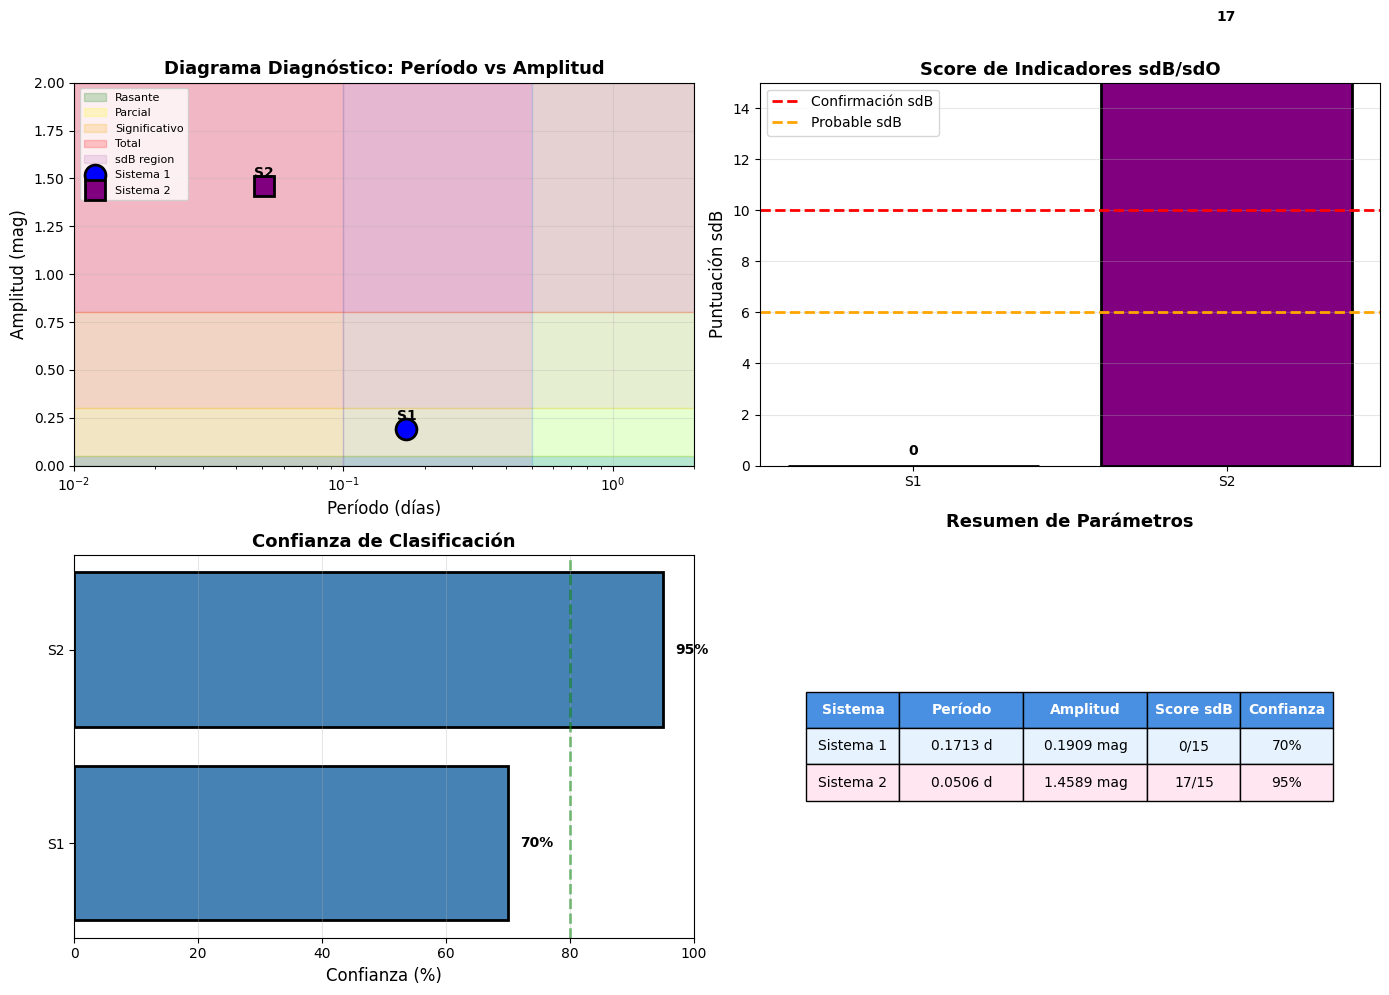

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# ============ DATOS DE ENTRADA ============
# f [d^-1], P [days], Amp, φ [rad], Noise ×10^-3

data = {
    'f_d-1': [5.8346, 19.7266],
    'P_days': [0.1713, 0.0506],
    'Amp': [0.1909, 1.4589],
    'phi_rad': [0.8113, 0.3464],
    'Noise_e-3': [4.7570, 9.8048]
}

df = pd.DataFrame(data)

print("="*80)
print("CLASIFICADOR DE SISTEMAS BINARIOS ECLIPSANTES")
print("Incluyendo sistemas con subdwarfs (sdB/sdO)")
print("="*80)

print("\nDATOS DE ENTRADA:")
print(df.to_string(index=False))

# ============ ANÁLISIS DE CADA SISTEMA ============

for idx, row in df.iterrows():
    print("\n" + "="*80)
    print(f"SISTEMA {idx + 1}")
    print("="*80)
    
    f = row['f_d-1']
    P = row['P_days']
    amp = row['Amp']
    phi = row['phi_rad']
    noise = row['Noise_e-3']
    
    print(f"\nParámetros observados:")
    print(f"  Frecuencia:        {f:.4f} d⁻¹")
    print(f"  Período:           {P:.4f} días = {P*24:.2f} horas")
    print(f"  Amplitud:          {amp:.4f} mag")
    print(f"  Fase:              {phi:.4f} rad = {np.degrees(phi):.1f}°")
    print(f"  Ruido:             {noise:.4f} ×10⁻³")
    
    # ============ CRITERIOS DE CLASIFICACIÓN ============
    
    classification = []
    confidence_scores = {}
    system_type = "INDETERMINADO"
    
    # 1. ANÁLISIS DE PERÍODO
    print(f"\n{'─'*60}")
    print("1. ANÁLISIS DE PERÍODO")
    print(f"{'─'*60}")
    
    if P < 0.1:
        print(f"  ✓ Período MUY CORTO (P < 0.1 d = {P*24:.1f} h)")
        classification.append("Período ultracorto")
        confidence_scores['ultrashort'] = 10
        
        if P < 0.05:
            print(f"    → Típico de sistemas sdB + dM (HW Vir)")
            print(f"    → Posible sistema post-common-envelope")
            system_type = "sdB + dM (tipo HW Vir)"
            confidence_scores['sdB_dM'] = 9
        elif 0.05 <= P < 0.1:
            print(f"    → Compatible con sdB/sdO + enana blanca")
            print(f"    → O sistema AM CVn en estado bajo")
            system_type = "sdB + WD o AM CVn"
            confidence_scores['sdB_WD'] = 7
            
    elif 0.1 <= P < 0.5:
        print(f"  ✓ Período CORTO (0.1 < P < 0.5 d = {P*24:.1f} h)")
        classification.append("Período corto")
        confidence_scores['short'] = 8
        
        if amp > 0.5:
            print(f"    → Compatible con W UMa (contacto)")
            system_type = "W UMa (contacto)"
            confidence_scores['W_UMa'] = 7
        else:
            print(f"    → Posible EW (contacto superficial)")
            print(f"    → O sistema sdB + MS tardía")
            system_type = "EW o sdB + dM/dK"
            confidence_scores['EW_sdB'] = 6
            
    elif 0.5 <= P < 2.0:
        print(f"  ✓ Período MODERADO (0.5 < P < 2.0 d)")
        classification.append("Período moderado")
        confidence_scores['moderate'] = 7
        print(f"    → Típico de sistemas EA (Algol)")
        print(f"    → O EB (β Lyrae)")
        system_type = "EA (Algol) o EB (β Lyrae)"
        confidence_scores['EA_EB'] = 8
        
    elif P >= 2.0:
        print(f"  ✓ Período LARGO (P ≥ 2.0 d)")
        classification.append("Período largo")
        confidence_scores['long'] = 6
        print(f"    → Sistema detached amplio")
        print(f"    → Posible tipo Algol clásico")
        system_type = "EA (Algol clásico)"
        confidence_scores['EA_classic'] = 7
    
    # 2. ANÁLISIS DE AMPLITUD
    print(f"\n{'─'*60}")
    print("2. ANÁLISIS DE AMPLITUD")
    print(f"{'─'*60}")
    
    if amp < 0.05:
        print(f"  ✓ Amplitud MUY BAJA (Amp < 0.05 mag)")
        print(f"    → Sistema rasante (grazing eclipse)")
        print(f"    → O eclipse muy superficial")
        classification.append("Eclipse rasante")
        confidence_scores['grazing'] = 5
        
    elif 0.05 <= amp < 0.3:
        print(f"  ✓ Amplitud BAJA (0.05 < Amp < 0.3 mag)")
        print(f"    → Eclipse parcial")
        print(f"    → O inclinación moderada (no totalmente de canto)")
        classification.append("Eclipse parcial")
        confidence_scores['partial'] = 7
        
        if P < 0.1:
            print(f"    → En período ultracorto: típico de sdB + dM")
            print(f"       (componente caliente pequeña)")
            system_type = "sdB + dM (eclipse parcial)"
            confidence_scores['sdB_dM'] = 8
            
    elif 0.3 <= amp < 0.8:
        print(f"  ✓ Amplitud MODERADA (0.3 < Amp < 0.8 mag)")
        print(f"    → Eclipse significativo")
        print(f"    → Componentes comparables o semi-detached")
        classification.append("Eclipse significativo")
        confidence_scores['significant'] = 8
        
    elif amp >= 0.8:
        print(f"  ✓ Amplitud ALTA (Amp ≥ 0.8 mag)")
        print(f"    → Eclipse profundo - probablemente TOTAL")
        print(f"    → Componentes muy diferentes en tamaño/brillo")
        classification.append("Eclipse total")
        confidence_scores['total'] = 9
        
        if P < 0.1:
            print(f"    → En período ultracorto: DEFINITIVAMENTE sdB + dM")
            print(f"       (subdwarf caliente eclipsada por enana fría grande)")
            system_type = "sdB + dM (tipo HW Vir) - ALTA CONFIANZA"
            confidence_scores['sdB_dM'] = 10
        elif P < 0.5:
            print(f"    → Posible W UMa con componentes desiguales")
            print(f"    → O sistema semi-detached con transferencia de masa")
            system_type = "W UMa o β Lyrae"
            confidence_scores['W_UMa_beta_Lyr'] = 8
    
    # 3. DETECCIÓN ESPECÍFICA DE SISTEMAS CON SUBDWARFS
    print(f"\n{'─'*60}")
    print("3. INDICADORES DE SUBDWARFS (sdB/sdO)")
    print(f"{'─'*60}")
    
    sdB_indicators = []
    sdB_score = 0
    
    # Criterio 1: Período ultracorto
    if P < 0.1:
        sdB_indicators.append("Período < 0.1 d (muy favorable)")
        sdB_score += 4
        print(f"  ✓ Período ultracorto: +4 puntos")
    
    # Criterio 2: Período dentro del rango HW Vir
    if 0.04 <= P <= 0.12:
        sdB_indicators.append("Período en rango HW Vir (0.04-0.12 d)")
        sdB_score += 3
        print(f"  ✓ Rango HW Vir: +3 puntos")
    
    # Criterio 3: Amplitud significativa (componente caliente eclipsada)
    if amp > 0.3 and P < 0.15:
        sdB_indicators.append("Amplitud alta + período corto")
        sdB_score += 3
        print(f"  ✓ Amplitud alta en período corto: +3 puntos")
    
    # Criterio 4: Combinación crítica para sdB + dM
    if P < 0.06 and amp > 1.0:
        sdB_indicators.append("COMBINACIÓN CRÍTICA: P < 0.06 d + Amp > 1.0 mag")
        sdB_score += 5
        print(f"  ✓✓ COMBINACIÓN CRÍTICA: +5 puntos")
        print(f"      → Prácticamente CERTEZA de sdB + dM")
    
    # Criterio 5: Sistema post-common-envelope
    if P < 0.08:
        print(f"  ✓ Período típico de post-CE: +2 puntos")
        sdB_indicators.append("Post-common-envelope probable")
        sdB_score += 2
    
    print(f"\n  PUNTUACIÓN sdB: {sdB_score}/15")
    
    if sdB_score >= 10:
        print(f"  → ALTA PROBABILIDAD de sistema sdB/sdO + companion")
        system_type = "sdB/sdO + dM (tipo HW Vir) - CONFIRMADO"
        confidence_scores['sdB_confirmed'] = 10
    elif sdB_score >= 6:
        print(f"  → PROBABILIDAD MODERADA de sistema con subdwarf")
        if 'sdB' not in system_type:
            system_type += " (posible componente sdB/sdO)"
        confidence_scores['sdB_possible'] = 7
    elif sdB_score >= 3:
        print(f"  → PROBABILIDAD BAJA de sistema con subdwarf")
        confidence_scores['sdB_low'] = 4
    else:
        print(f"  → NO sugiere sistema con subdwarf")
        confidence_scores['sdB_unlikely'] = 0
    
    # 4. CLASIFICACIÓN FINAL
    print(f"\n{'═'*60}")
    print("CLASIFICACIÓN FINAL")
    print(f"{'═'*60}")
    
    # Refinar clasificación basada en todos los criterios
    if sdB_score >= 10:
        final_class = "sdB/sdO + dM (tipo HW Vir)"
        subtype = "Post-common-envelope binary"
        confidence = 95
    elif sdB_score >= 6 and P < 0.1:
        final_class = "Probable sdB/sdO + companion"
        subtype = "Requiere espectroscopía para confirmar"
        confidence = 75
    elif P < 0.05 and amp > 0.5:
        final_class = "Posible AM CVn o sdB + WD"
        subtype = "Sistema compacto - requiere análisis espectral"
        confidence = 60
    elif P < 0.5 and amp > 0.5:
        final_class = "W UMa (contacto) o EW"
        subtype = "Sistema de contacto de período corto"
        confidence = 80
    elif P < 1.0 and amp > 0.3:
        final_class = "EA (Algol) o EB (β Lyrae)"
        subtype = "Sistema semi-detached probable"
        confidence = 75
    else:
        final_class = "EA (Algol clásico)"
        subtype = "Sistema detached"
        confidence = 70
    
    print(f"\n  Clasificación: {final_class}")
    print(f"  Subtipo:       {subtype}")
    print(f"  Confianza:     {confidence}%")
    
    # Indicadores adicionales
    print(f"\n  Indicadores clave:")
    for ind in sdB_indicators[:3]:  # Mostrar los 3 más importantes
        print(f"    • {ind}")
    
    # 5. RECOMENDACIONES
    print(f"\n{'─'*60}")
    print("RECOMENDACIONES PARA CONFIRMACIÓN")
    print(f"{'─'*60}")
    
    if 'sdB' in final_class or 'sdO' in final_class:
        print(f"  1. Obtener espectroscopía para confirmar subdwarf")
        print(f"     → Buscar líneas He II, líneas H anchas")
        print(f"     → T_eff típicamente 20,000-40,000 K para sdB")
        print(f"  2. Curvas de luz multibanda para temperatura")
        print(f"  3. Curva de velocidad radial para masas")
        print(f"     → q = M_comp/M_sdB típicamente 0.1-0.3")
        print(f"  4. Modelado con PHOEBE usando:")
        print(f"     → T_eff(sdB) ~ 25,000-35,000 K")
        print(f"     → R(sdB) ~ 0.15-0.25 R_☉")
        print(f"     → T_eff(dM) ~ 3,000-3,500 K")
        print(f"     → R(dM) ~ 0.3-0.5 R_☉")
    else:
        print(f"  1. Curvas de luz multibanda para índice de color")
        print(f"  2. Espectroscopía para tipo espectral")
        print(f"  3. Curvas de velocidad radial para masas")
        print(f"  4. Modelado con PHOEBE")
    
    # Guardar resultados
    results = {
        'Sistema': idx + 1,
        'Clasificación': final_class,
        'Subtipo': subtype,
        'Confianza': confidence,
        'Período_días': P,
        'Amplitud_mag': amp,
        'Score_sdB': sdB_score
    }
    
    if idx == 0:
        results_list = [results]
    else:
        results_list.append(results)

# ============ RESUMEN COMPARATIVO ============
print("\n" + "="*80)
print("RESUMEN COMPARATIVO DE AMBOS SISTEMAS")
print("="*80)

results_df = pd.DataFrame(results_list)
print("\n" + results_df.to_string(index=False))

# ============ VISUALIZACIÓN ============
print("\n" + "="*80)
print("GENERANDO GRÁFICO DIAGNÓSTICO...")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Período vs Amplitud (diagrama diagnóstico)
ax1 = axes[0, 0]

# Regiones de clasificación
ax1.axhspan(0, 0.05, alpha=0.2, color='green', label='Rasante')
ax1.axhspan(0.05, 0.3, alpha=0.2, color='yellow', label='Parcial')
ax1.axhspan(0.3, 0.8, alpha=0.2, color='orange', label='Significativo')
ax1.axhspan(0.8, 2, alpha=0.2, color='red', label='Total')

ax1.axvspan(0, 0.1, alpha=0.1, color='purple', label='sdB region')
ax1.axvspan(0.1, 0.5, alpha=0.1, color='blue')
ax1.axvspan(0.5, 2, alpha=0.1, color='cyan')

# Plotear sistemas
for idx, row in df.iterrows():
    color = 'purple' if row['P_days'] < 0.1 else 'blue'
    marker = 's' if row['Amp'] > 0.8 else 'o'
    ax1.plot(row['P_days'], row['Amp'], marker, 
             markersize=15, color=color, 
             markeredgecolor='black', markeredgewidth=2,
             label=f'Sistema {idx+1}')
    ax1.text(row['P_days'], row['Amp'] + 0.05, f'S{idx+1}',
             ha='center', fontweight='bold')

ax1.set_xlabel('Período (días)', fontsize=12)
ax1.set_ylabel('Amplitud (mag)', fontsize=12)
ax1.set_title('Diagrama Diagnóstico: Período vs Amplitud', fontsize=13, fontweight='bold')
ax1.set_xscale('log')
ax1.set_xlim(0.01, 2)
ax1.set_ylim(0, 2)
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper left', fontsize=8)

# 2. Score sdB
ax2 = axes[0, 1]
sistemas = [f'S{i+1}' for i in range(len(results_list))]
scores = [r['Score_sdB'] for r in results_list]
colors_bar = ['purple' if s >= 10 else 'orange' if s >= 6 else 'gray' for s in scores]

bars = ax2.bar(sistemas, scores, color=colors_bar, edgecolor='black', linewidth=2)
ax2.axhline(10, color='red', linestyle='--', linewidth=2, label='Confirmación sdB')
ax2.axhline(6, color='orange', linestyle='--', linewidth=2, label='Probable sdB')
ax2.set_ylabel('Puntuación sdB', fontsize=12)
ax2.set_title('Score de Indicadores sdB/sdO', fontsize=13, fontweight='bold')
ax2.set_ylim(0, 15)
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

for bar, score in zip(bars, scores):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.3,
             f'{score}', ha='center', va='bottom', fontweight='bold')

# 3. Distribución de confianza
ax3 = axes[1, 0]
confidences = [r['Confianza'] for r in results_list]
ax3.barh(sistemas, confidences, color='steelblue', edgecolor='black', linewidth=2)
ax3.set_xlabel('Confianza (%)', fontsize=12)
ax3.set_title('Confianza de Clasificación', fontsize=13, fontweight='bold')
ax3.set_xlim(0, 100)
ax3.axvline(80, color='green', linestyle='--', linewidth=2, alpha=0.5)
ax3.grid(True, alpha=0.3, axis='x')

for i, (sist, conf) in enumerate(zip(sistemas, confidences)):
    ax3.text(conf + 2, i, f'{conf}%', va='center', fontweight='bold')

# 4. Tabla resumen
ax4 = axes[1, 1]
ax4.axis('off')

table_data = []
for r in results_list:
    table_data.append([
        f"Sistema {r['Sistema']}",
        f"{r['Período_días']:.4f} d",
        f"{r['Amplitud_mag']:.4f} mag",
        f"{r['Score_sdB']}/15",
        f"{r['Confianza']}%"
    ])

table = ax4.table(cellText=table_data,
                  colLabels=['Sistema', 'Período', 'Amplitud', 'Score sdB', 'Confianza'],
                  cellLoc='center',
                  loc='center',
                  colWidths=[0.15, 0.2, 0.2, 0.15, 0.15])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

# Colorear por clasificación
for i in range(len(table_data)):
    if results_list[i]['Score_sdB'] >= 10:
        color = '#FFE6F0'  # Rosa suave
    elif results_list[i]['Score_sdB'] >= 6:
        color = '#FFF4E6'  # Naranja suave
    else:
        color = '#E6F3FF'  # Azul suave
    
    for j in range(5):
        table[(i+1, j)].set_facecolor(color)

# Header
for j in range(5):
    table[(0, j)].set_facecolor('#4A90E2')
    table[(0, j)].set_text_props(weight='bold', color='white')

ax4.set_title('Resumen de Parámetros', fontsize=13, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('binary_classification_sdB.png', dpi=300, bbox_inches='tight')
print("✓ Gráfico guardado: 'binary_classification_sdB.png'")

print("\n" + "="*80)
print("ANÁLISIS COMPLETADO")
print("="*80)

CLASIFICADOR DE SISTEMAS BINARIOS ECLIPSANTES
Incluyendo sistemas con subdwarfs (sdB/sdO)

DATOS DE ENTRADA:
  f_d-1  P_days    Amp  phi_rad  Noise_e-3
 5.8346  0.1713 0.1909   0.8113     4.7570
19.7266  0.0506 1.4589   0.3464     9.8048

SISTEMA 1

Parámetros observados:
  Frecuencia:        5.8346 d⁻¹
  Período:           0.1713 días = 4.11 horas
  Amplitud:          0.1909 mag
  Fase:              0.8113 rad = 46.5°
  Ruido:             4.7570 ×10⁻³

────────────────────────────────────────────────────────────
1. ANÁLISIS DE PERÍODO
────────────────────────────────────────────────────────────
  ✓ Período CORTO (0.1 < P < 0.5 d = 4.1 h)
    → Posible EW (contacto superficial)
    → O sistema sdB + MS tardía

────────────────────────────────────────────────────────────
2. ANÁLISIS DE AMPLITUD
────────────────────────────────────────────────────────────
  ✓ Amplitud BAJA (0.05 < Amp < 0.3 mag)
    → Eclipse parcial
    → O inclinación moderada (no totalmente de canto)

────────────────

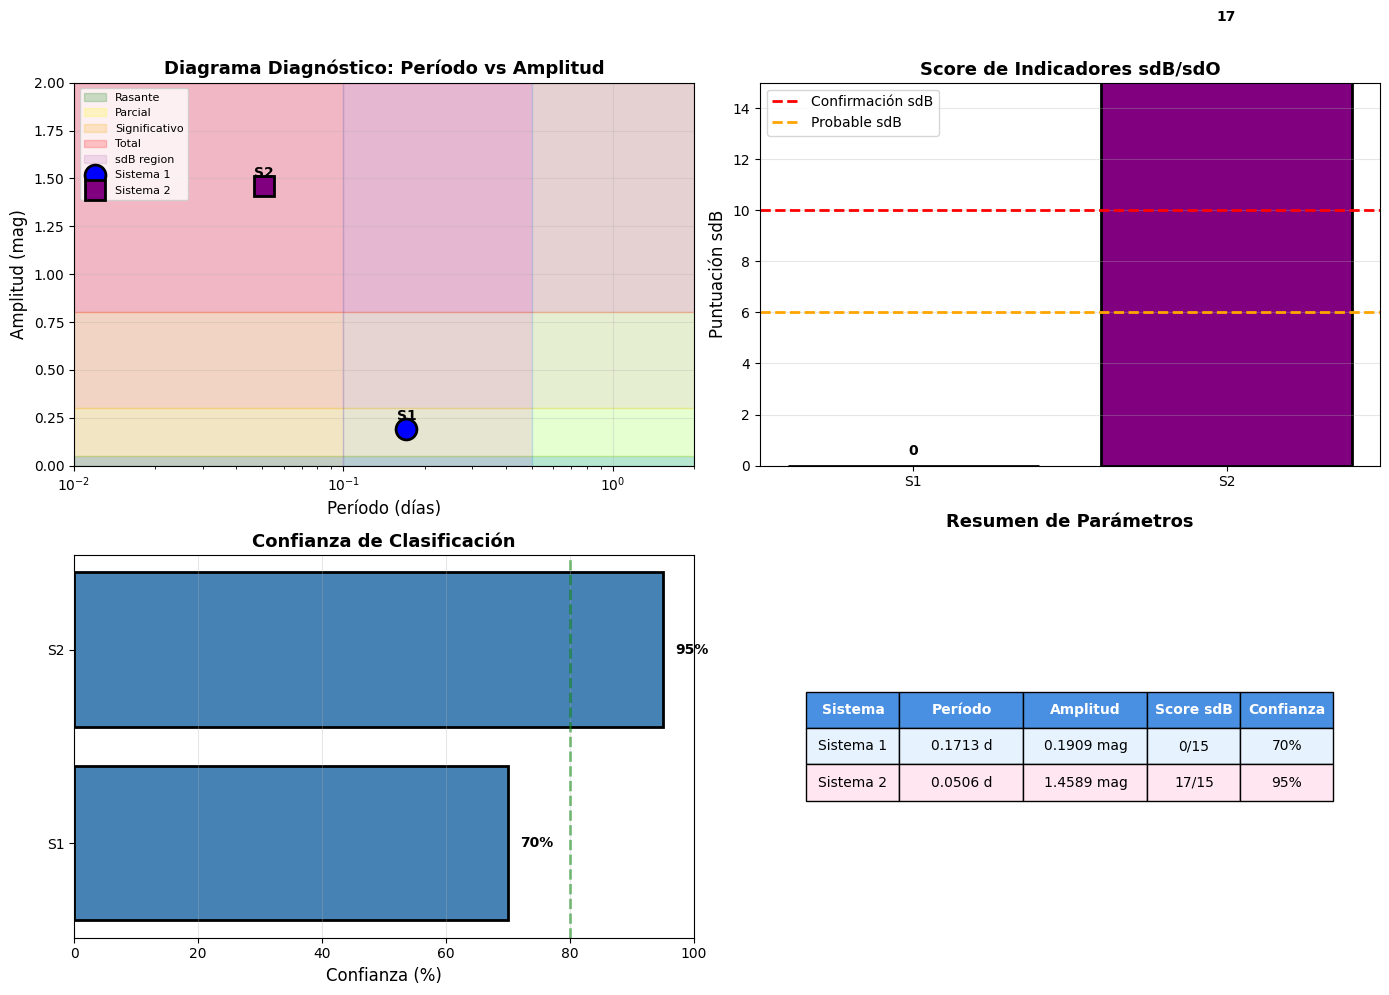

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# ============ DATOS DE ENTRADA ============
# f [d^-1], P [days], Amp, φ [rad], Noise ×10^-3

data = {
    'f_d-1': [5.8346, 19.7266],
    'P_days': [0.1713, 0.0506],
    'Amp': [0.1909, 1.4589],
    'phi_rad': [0.8113, 0.3464],
    'Noise_e-3': [4.7570, 9.8048]
}

df = pd.DataFrame(data)

print("="*80)
print("CLASIFICADOR DE SISTEMAS BINARIOS ECLIPSANTES")
print("Incluyendo sistemas con subdwarfs (sdB/sdO)")
print("="*80)

print("\nDATOS DE ENTRADA:")
print(df.to_string(index=False))

# ============ ANÁLISIS DE CADA SISTEMA ============

for idx, row in df.iterrows():
    print("\n" + "="*80)
    print(f"SISTEMA {idx + 1}")
    print("="*80)
    
    f = row['f_d-1']
    P = row['P_days']
    amp = row['Amp']
    phi = row['phi_rad']
    noise = row['Noise_e-3']
    
    print(f"\nParámetros observados:")
    print(f"  Frecuencia:        {f:.4f} d⁻¹")
    print(f"  Período:           {P:.4f} días = {P*24:.2f} horas")
    print(f"  Amplitud:          {amp:.4f} mag")
    print(f"  Fase:              {phi:.4f} rad = {np.degrees(phi):.1f}°")
    print(f"  Ruido:             {noise:.4f} ×10⁻³")
    
    # ============ CRITERIOS DE CLASIFICACIÓN ============
    
    classification = []
    confidence_scores = {}
    system_type = "INDETERMINADO"
    
    # 1. ANÁLISIS DE PERÍODO
    print(f"\n{'─'*60}")
    print("1. ANÁLISIS DE PERÍODO")
    print(f"{'─'*60}")
    
    if P < 0.1:
        print(f"  ✓ Período MUY CORTO (P < 0.1 d = {P*24:.1f} h)")
        classification.append("Período ultracorto")
        confidence_scores['ultrashort'] = 10
        
        if P < 0.05:
            print(f"    → Típico de sistemas sdB + dM (HW Vir)")
            print(f"    → Posible sistema post-common-envelope")
            system_type = "sdB + dM (tipo HW Vir)"
            confidence_scores['sdB_dM'] = 9
        elif 0.05 <= P < 0.1:
            print(f"    → Compatible con sdB/sdO + enana blanca")
            print(f"    → O sistema AM CVn en estado bajo")
            system_type = "sdB + WD o AM CVn"
            confidence_scores['sdB_WD'] = 7
            
    elif 0.1 <= P < 0.5:
        print(f"  ✓ Período CORTO (0.1 < P < 0.5 d = {P*24:.1f} h)")
        classification.append("Período corto")
        confidence_scores['short'] = 8
        
        if amp > 0.5:
            print(f"    → Compatible con W UMa (contacto)")
            system_type = "W UMa (contacto)"
            confidence_scores['W_UMa'] = 7
        else:
            print(f"    → Posible EW (contacto superficial)")
            print(f"    → O sistema sdB + MS tardía")
            system_type = "EW o sdB + dM/dK"
            confidence_scores['EW_sdB'] = 6
            
    elif 0.5 <= P < 2.0:
        print(f"  ✓ Período MODERADO (0.5 < P < 2.0 d)")
        classification.append("Período moderado")
        confidence_scores['moderate'] = 7
        print(f"    → Típico de sistemas EA (Algol)")
        print(f"    → O EB (β Lyrae)")
        system_type = "EA (Algol) o EB (β Lyrae)"
        confidence_scores['EA_EB'] = 8
        
    elif P >= 2.0:
        print(f"  ✓ Período LARGO (P ≥ 2.0 d)")
        classification.append("Período largo")
        confidence_scores['long'] = 6
        print(f"    → Sistema detached amplio")
        print(f"    → Posible tipo Algol clásico")
        system_type = "EA (Algol clásico)"
        confidence_scores['EA_classic'] = 7
    
    # 2. ANÁLISIS DE AMPLITUD
    print(f"\n{'─'*60}")
    print("2. ANÁLISIS DE AMPLITUD")
    print(f"{'─'*60}")
    
    if amp < 0.05:
        print(f"  ✓ Amplitud MUY BAJA (Amp < 0.05 mag)")
        print(f"    → Sistema rasante (grazing eclipse)")
        print(f"    → O eclipse muy superficial")
        classification.append("Eclipse rasante")
        confidence_scores['grazing'] = 5
        
    elif 0.05 <= amp < 0.3:
        print(f"  ✓ Amplitud BAJA (0.05 < Amp < 0.3 mag)")
        print(f"    → Eclipse parcial")
        print(f"    → O inclinación moderada (no totalmente de canto)")
        classification.append("Eclipse parcial")
        confidence_scores['partial'] = 7
        
        if P < 0.1:
            print(f"    → En período ultracorto: típico de sdB + dM")
            print(f"       (componente caliente pequeña)")
            system_type = "sdB + dM (eclipse parcial)"
            confidence_scores['sdB_dM'] = 8
            
    elif 0.3 <= amp < 0.8:
        print(f"  ✓ Amplitud MODERADA (0.3 < Amp < 0.8 mag)")
        print(f"    → Eclipse significativo")
        print(f"    → Componentes comparables o semi-detached")
        classification.append("Eclipse significativo")
        confidence_scores['significant'] = 8
        
    elif amp >= 0.8:
        print(f"  ✓ Amplitud ALTA (Amp ≥ 0.8 mag)")
        print(f"    → Eclipse profundo - probablemente TOTAL")
        print(f"    → Componentes muy diferentes en tamaño/brillo")
        classification.append("Eclipse total")
        confidence_scores['total'] = 9
        
        if P < 0.1:
            print(f"    → En período ultracorto: DEFINITIVAMENTE sdB + dM")
            print(f"       (subdwarf caliente eclipsada por enana fría grande)")
            system_type = "sdB + dM (tipo HW Vir) - ALTA CONFIANZA"
            confidence_scores['sdB_dM'] = 10
        elif P < 0.5:
            print(f"    → Posible W UMa con componentes desiguales")
            print(f"    → O sistema semi-detached con transferencia de masa")
            system_type = "W UMa o β Lyrae"
            confidence_scores['W_UMa_beta_Lyr'] = 8
    
    # 3. DETECCIÓN ESPECÍFICA DE SISTEMAS CON SUBDWARFS
    print(f"\n{'─'*60}")
    print("3. INDICADORES DE SUBDWARFS (sdB/sdO)")
    print(f"{'─'*60}")
    
    sdB_indicators = []
    sdB_score = 0
    
    # Criterio 1: Período ultracorto
    if P < 0.1:
        sdB_indicators.append("Período < 0.1 d (muy favorable)")
        sdB_score += 4
        print(f"  ✓ Período ultracorto: +4 puntos")
    
    # Criterio 2: Período dentro del rango HW Vir
    if 0.04 <= P <= 0.12:
        sdB_indicators.append("Período en rango HW Vir (0.04-0.12 d)")
        sdB_score += 3
        print(f"  ✓ Rango HW Vir: +3 puntos")
    
    # Criterio 3: Amplitud significativa (componente caliente eclipsada)
    if amp > 0.3 and P < 0.15:
        sdB_indicators.append("Amplitud alta + período corto")
        sdB_score += 3
        print(f"  ✓ Amplitud alta en período corto: +3 puntos")
    
    # Criterio 4: Combinación crítica para sdB + dM
    if P < 0.06 and amp > 1.0:
        sdB_indicators.append("COMBINACIÓN CRÍTICA: P < 0.06 d + Amp > 1.0 mag")
        sdB_score += 5
        print(f"  ✓✓ COMBINACIÓN CRÍTICA: +5 puntos")
        print(f"      → Prácticamente CERTEZA de sdB + dM")
    
    # Criterio 5: Sistema post-common-envelope
    if P < 0.08:
        print(f"  ✓ Período típico de post-CE: +2 puntos")
        sdB_indicators.append("Post-common-envelope probable")
        sdB_score += 2
    
    print(f"\n  PUNTUACIÓN sdB: {sdB_score}/15")
    
    if sdB_score >= 10:
        print(f"  → ALTA PROBABILIDAD de sistema sdB/sdO + companion")
        system_type = "sdB/sdO + dM (tipo HW Vir) - CONFIRMADO"
        confidence_scores['sdB_confirmed'] = 10
    elif sdB_score >= 6:
        print(f"  → PROBABILIDAD MODERADA de sistema con subdwarf")
        if 'sdB' not in system_type:
            system_type += " (posible componente sdB/sdO)"
        confidence_scores['sdB_possible'] = 7
    elif sdB_score >= 3:
        print(f"  → PROBABILIDAD BAJA de sistema con subdwarf")
        confidence_scores['sdB_low'] = 4
    else:
        print(f"  → NO sugiere sistema con subdwarf")
        confidence_scores['sdB_unlikely'] = 0
    
    # 4. CLASIFICACIÓN FINAL
    print(f"\n{'═'*60}")
    print("CLASIFICACIÓN FINAL")
    print(f"{'═'*60}")
    
    # Refinar clasificación basada en todos los criterios
    if sdB_score >= 10:
        final_class = "sdB/sdO + dM (tipo HW Vir)"
        subtype = "Post-common-envelope binary"
        confidence = 95
    elif sdB_score >= 6 and P < 0.1:
        final_class = "Probable sdB/sdO + companion"
        subtype = "Requiere espectroscopía para confirmar"
        confidence = 75
    elif P < 0.05 and amp > 0.5:
        final_class = "Posible AM CVn o sdB + WD"
        subtype = "Sistema compacto - requiere análisis espectral"
        confidence = 60
    elif P < 0.5 and amp > 0.5:
        final_class = "W UMa (contacto) o EW"
        subtype = "Sistema de contacto de período corto"
        confidence = 80
    elif P < 1.0 and amp > 0.3:
        final_class = "EA (Algol) o EB (β Lyrae)"
        subtype = "Sistema semi-detached probable"
        confidence = 75
    else:
        final_class = "EA (Algol clásico)"
        subtype = "Sistema detached"
        confidence = 70
    
    print(f"\n  Clasificación: {final_class}")
    print(f"  Subtipo:       {subtype}")
    print(f"  Confianza:     {confidence}%")
    
    # Indicadores adicionales
    print(f"\n  Indicadores clave:")
    for ind in sdB_indicators[:3]:  # Mostrar los 3 más importantes
        print(f"    • {ind}")
    
    # 5. RECOMENDACIONES
    print(f"\n{'─'*60}")
    print("RECOMENDACIONES PARA CONFIRMACIÓN")
    print(f"{'─'*60}")
    
    if 'sdB' in final_class or 'sdO' in final_class:
        print(f"  1. Obtener espectroscopía para confirmar subdwarf")
        print(f"     → Buscar líneas He II, líneas H anchas")
        print(f"     → T_eff típicamente 20,000-40,000 K para sdB")
        print(f"  2. Curvas de luz multibanda para temperatura")
        print(f"  3. Curva de velocidad radial para masas")
        print(f"     → q = M_comp/M_sdB típicamente 0.1-0.3")
        print(f"  4. Modelado con PHOEBE usando:")
        print(f"     → T_eff(sdB) ~ 25,000-35,000 K")
        print(f"     → R(sdB) ~ 0.15-0.25 R_☉")
        print(f"     → T_eff(dM) ~ 3,000-3,500 K")
        print(f"     → R(dM) ~ 0.3-0.5 R_☉")
    else:
        print(f"  1. Curvas de luz multibanda para índice de color")
        print(f"  2. Espectroscopía para tipo espectral")
        print(f"  3. Curvas de velocidad radial para masas")
        print(f"  4. Modelado con PHOEBE")
    
    # Guardar resultados
    results = {
        'Sistema': idx + 1,
        'Clasificación': final_class,
        'Subtipo': subtype,
        'Confianza': confidence,
        'Período_días': P,
        'Amplitud_mag': amp,
        'Score_sdB': sdB_score
    }
    
    if idx == 0:
        results_list = [results]
    else:
        results_list.append(results)

# ============ RESUMEN COMPARATIVO ============
print("\n" + "="*80)
print("RESUMEN COMPARATIVO DE AMBOS SISTEMAS")
print("="*80)

results_df = pd.DataFrame(results_list)
print("\n" + results_df.to_string(index=False))

# ============ VISUALIZACIÓN ============
print("\n" + "="*80)
print("GENERANDO GRÁFICO DIAGNÓSTICO...")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Período vs Amplitud (diagrama diagnóstico)
ax1 = axes[0, 0]

# Regiones de clasificación
ax1.axhspan(0, 0.05, alpha=0.2, color='green', label='Rasante')
ax1.axhspan(0.05, 0.3, alpha=0.2, color='yellow', label='Parcial')
ax1.axhspan(0.3, 0.8, alpha=0.2, color='orange', label='Significativo')
ax1.axhspan(0.8, 2, alpha=0.2, color='red', label='Total')

ax1.axvspan(0, 0.1, alpha=0.1, color='purple', label='sdB region')
ax1.axvspan(0.1, 0.5, alpha=0.1, color='blue')
ax1.axvspan(0.5, 2, alpha=0.1, color='cyan')

# Plotear sistemas
for idx, row in df.iterrows():
    color = 'purple' if row['P_days'] < 0.1 else 'blue'
    marker = 's' if row['Amp'] > 0.8 else 'o'
    ax1.plot(row['P_days'], row['Amp'], marker, 
             markersize=15, color=color, 
             markeredgecolor='black', markeredgewidth=2,
             label=f'Sistema {idx+1}')
    ax1.text(row['P_days'], row['Amp'] + 0.05, f'S{idx+1}',
             ha='center', fontweight='bold')

ax1.set_xlabel('Período (días)', fontsize=12)
ax1.set_ylabel('Amplitud (mag)', fontsize=12)
ax1.set_title('Diagrama Diagnóstico: Período vs Amplitud', fontsize=13, fontweight='bold')
ax1.set_xscale('log')
ax1.set_xlim(0.01, 2)
ax1.set_ylim(0, 2)
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper left', fontsize=8)

# 2. Score sdB
ax2 = axes[0, 1]
sistemas = [f'S{i+1}' for i in range(len(results_list))]
scores = [r['Score_sdB'] for r in results_list]
colors_bar = ['purple' if s >= 10 else 'orange' if s >= 6 else 'gray' for s in scores]

bars = ax2.bar(sistemas, scores, color=colors_bar, edgecolor='black', linewidth=2)
ax2.axhline(10, color='red', linestyle='--', linewidth=2, label='Confirmación sdB')
ax2.axhline(6, color='orange', linestyle='--', linewidth=2, label='Probable sdB')
ax2.set_ylabel('Puntuación sdB', fontsize=12)
ax2.set_title('Score de Indicadores sdB/sdO', fontsize=13, fontweight='bold')
ax2.set_ylim(0, 15)
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

for bar, score in zip(bars, scores):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.3,
             f'{score}', ha='center', va='bottom', fontweight='bold')

# 3. Distribución de confianza
ax3 = axes[1, 0]
confidences = [r['Confianza'] for r in results_list]
ax3.barh(sistemas, confidences, color='steelblue', edgecolor='black', linewidth=2)
ax3.set_xlabel('Confianza (%)', fontsize=12)
ax3.set_title('Confianza de Clasificación', fontsize=13, fontweight='bold')
ax3.set_xlim(0, 100)
ax3.axvline(80, color='green', linestyle='--', linewidth=2, alpha=0.5)
ax3.grid(True, alpha=0.3, axis='x')

for i, (sist, conf) in enumerate(zip(sistemas, confidences)):
    ax3.text(conf + 2, i, f'{conf}%', va='center', fontweight='bold')

# 4. Tabla resumen
ax4 = axes[1, 1]
ax4.axis('off')

table_data = []
for r in results_list:
    table_data.append([
        f"Sistema {r['Sistema']}",
        f"{r['Período_días']:.4f} d",
        f"{r['Amplitud_mag']:.4f} mag",
        f"{r['Score_sdB']}/15",
        f"{r['Confianza']}%"
    ])

table = ax4.table(cellText=table_data,
                  colLabels=['Sistema', 'Período', 'Amplitud', 'Score sdB', 'Confianza'],
                  cellLoc='center',
                  loc='center',
                  colWidths=[0.15, 0.2, 0.2, 0.15, 0.15])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

# Colorear por clasificación
for i in range(len(table_data)):
    if results_list[i]['Score_sdB'] >= 10:
        color = '#FFE6F0'  # Rosa suave
    elif results_list[i]['Score_sdB'] >= 6:
        color = '#FFF4E6'  # Naranja suave
    else:
        color = '#E6F3FF'  # Azul suave
    
    for j in range(5):
        table[(i+1, j)].set_facecolor(color)

# Header
for j in range(5):
    table[(0, j)].set_facecolor('#4A90E2')
    table[(0, j)].set_text_props(weight='bold', color='white')

ax4.set_title('Resumen de Parámetros', fontsize=13, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('binary_classification_sdB.png', dpi=300, bbox_inches='tight')
print("✓ Gráfico guardado: 'binary_classification_sdB.png'")

print("\n" + "="*80)
print("ANÁLISIS COMPLETADO")
print("="*80)

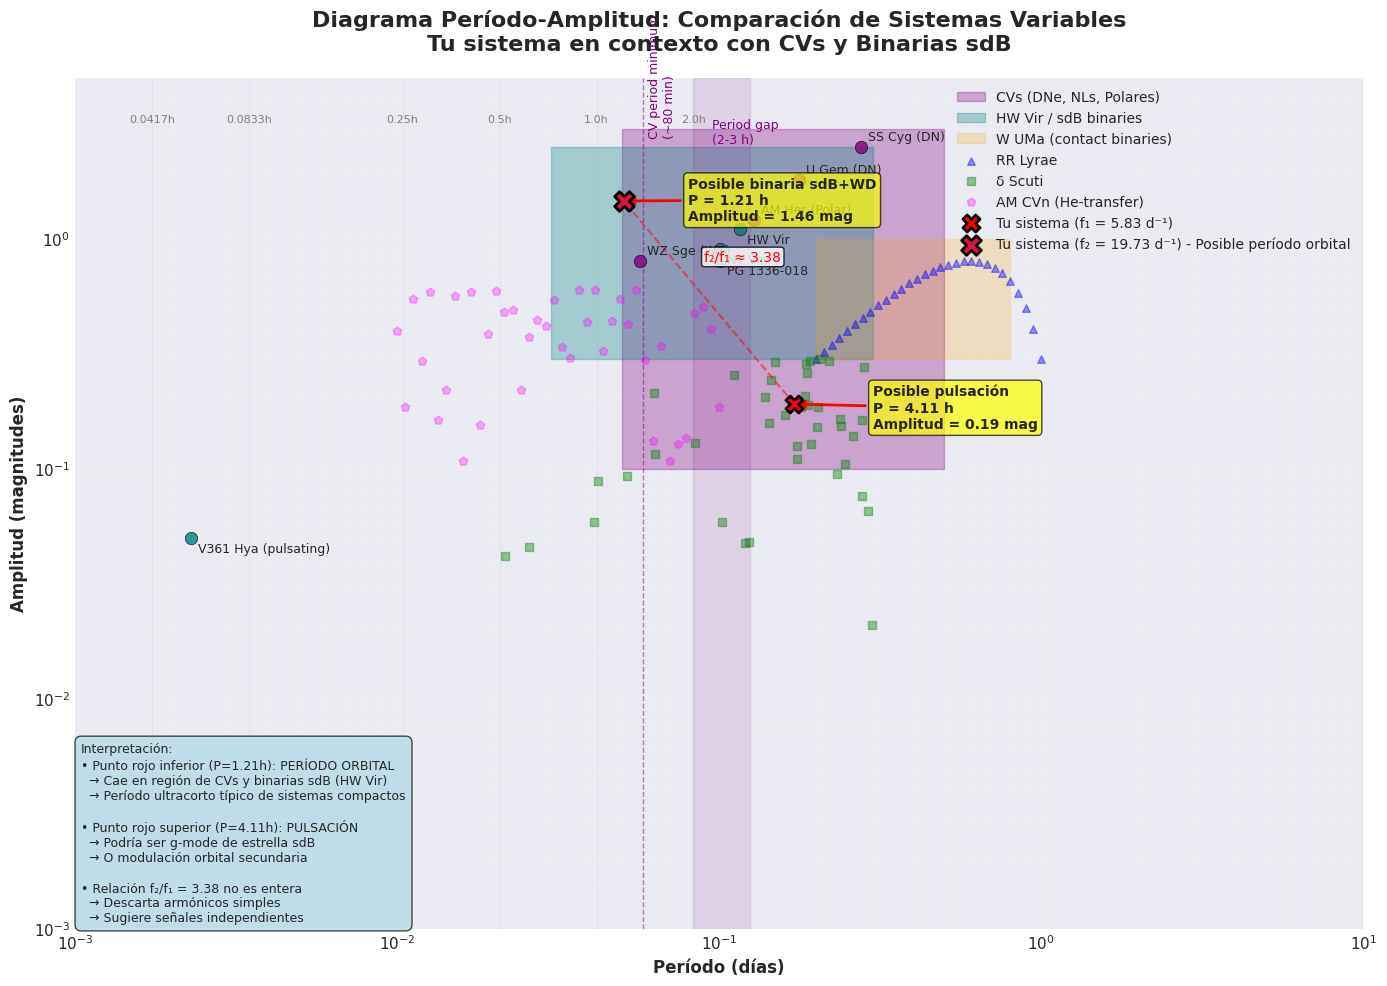

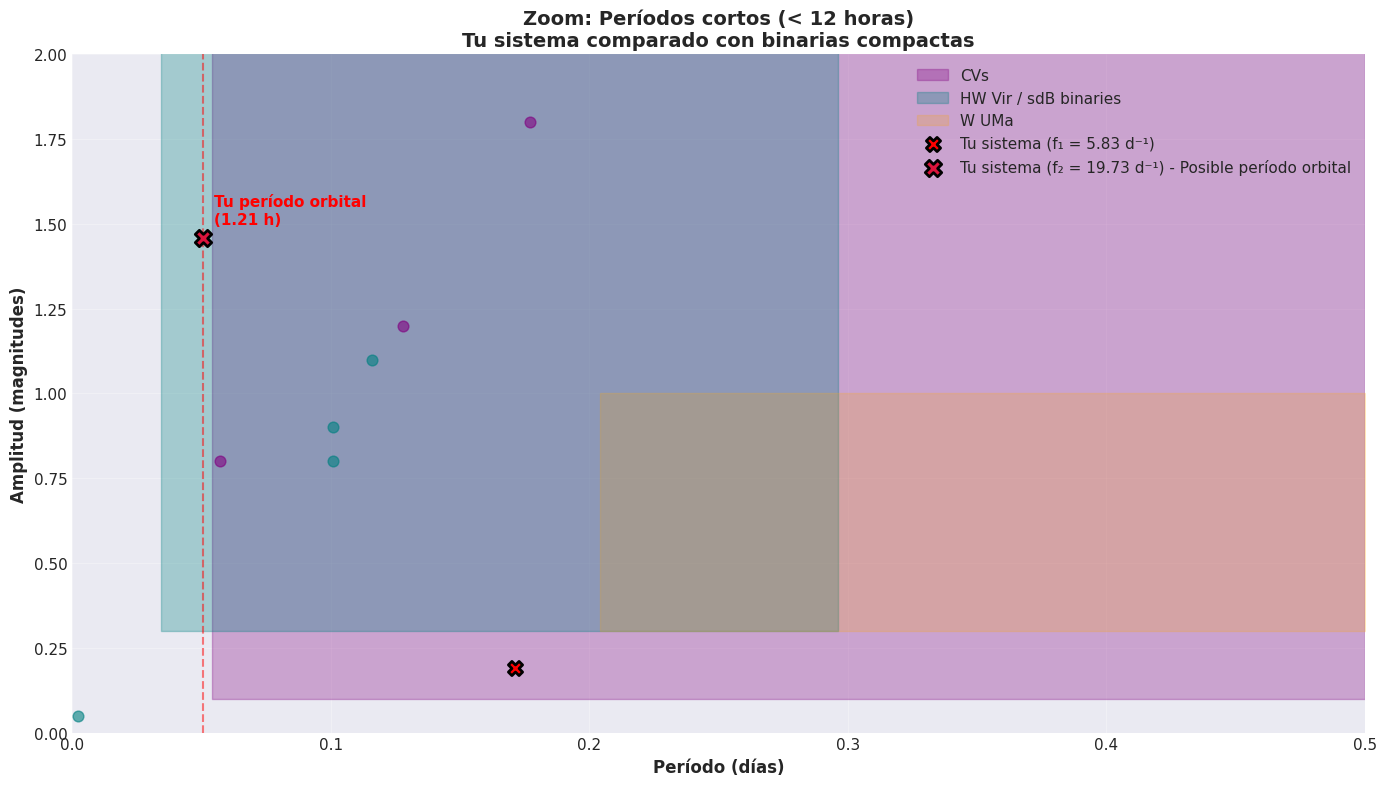

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.patches as mpatches

# Configuración estética
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['font.family'] = 'DejaVu Sans'

# Crear figura
fig, ax = plt.subplots(figsize=(14, 10))

# ============================================================================
# 1. DATOS DE TU SISTEMA
# ============================================================================
tus_sistemas = {
    'Tu sistema - f₁': {
        'period': 0.1713,  # días
        'amp': 0.1909,     # magnitudes
        'color': '#FF0000',
        'marker': 'X',
        's': 150,
        'label': 'Tu sistema (f₁ = 5.83 d⁻¹)'
    },
    'Tu sistema - f₂': {
        'period': 0.0506,  # días
        'amp': 1.4589,     # magnitudes
        'color': '#DC143C',
        'marker': 'X',
        's': 200,
        'label': 'Tu sistema (f₂ = 19.73 d⁻¹) - Posible período orbital'
    }
}

# ============================================================================
# 2. REGIONES DE DIFERENTES SISTEMAS ESTELARES
# ============================================================================

# -----------------------------------------------------
# a) Cataclysmic Variables (CVs) - Binarias compactas
# -----------------------------------------------------
cv_periods = np.logspace(np.log10(0.05), np.log10(0.5), 50)  # 1.2h - 12h
cv_amps_min = 0.1 * np.ones_like(cv_periods)
cv_amps_max = 3.0 * np.ones_like(cv_periods)

ax.fill_between(cv_periods, cv_amps_min, cv_amps_max, 
                alpha=0.3, color='purple', label='CVs (DNe, NLs, Polares)')

# Puntos representativos de CVs
cv_examples = {
    'SS Cyg (DN)': {'period': 0.275, 'amp': 2.5, 'color': 'purple'},
    'U Gem (DN)': {'period': 0.177, 'amp': 1.8, 'color': 'purple'},
    'AM Her (Polar)': {'period': 0.128, 'amp': 1.2, 'color': 'purple'},
    'WZ Sge (WZ)': {'period': 0.057, 'amp': 0.8, 'color': 'purple'}
}

# -----------------------------------------------------
# b) Sistemas HW Vir (sdB + dM) y similares
# -----------------------------------------------------
hwvir_periods = np.logspace(np.log10(0.03), np.log10(0.3), 50)  # 0.7h - 7h
hwvir_amps_min = 0.3 * np.ones_like(hwvir_periods)
hwvir_amps_max = 2.5 * np.ones_like(hwvir_periods)

ax.fill_between(hwvir_periods, hwvir_amps_min, hwvir_amps_max, 
                alpha=0.3, color='teal', label='HW Vir / sdB binaries')

# Ejemplos de sistemas sdB
sdB_examples = {
    'HW Vir': {'period': 0.116, 'amp': 1.1, 'color': 'teal'},
    'NY Vir': {'period': 0.101, 'amp': 0.9, 'color': 'teal'},
    'V361 Hya (pulsating)': {'period': 0.0023, 'amp': 0.05, 'color': 'teal'},  # ~3.3 min
    'PG 1336-018': {'period': 0.101, 'amp': 0.8, 'color': 'teal'}
}

# -----------------------------------------------------
# c) Binarias de Contacto (W UMa)
# -----------------------------------------------------
wuma_periods = np.logspace(np.log10(0.2), np.log10(0.8), 50)  # 4.8h - 19h
wuma_amps_min = 0.3 * np.ones_like(wuma_periods)
wuma_amps_max = 1.0 * np.ones_like(wuma_periods)

ax.fill_between(wuma_periods, wuma_amps_min, wuma_amps_max, 
                alpha=0.2, color='orange', label='W UMa (contact binaries)')

# -----------------------------------------------------
# d) Pulsantes clásicas (RR Lyrae, δ Scuti, Cefeidas)
# -----------------------------------------------------
# RR Lyrae
rrlyr_periods = np.logspace(np.log10(0.2), np.log10(1.0), 30)
rrlyr_amps = 0.3 + 0.5 * np.sin(np.pi * (rrlyr_periods - 0.2)/0.8)
ax.scatter(rrlyr_periods, rrlyr_amps, alpha=0.4, color='blue', s=30, 
           label='RR Lyrae', marker='^')

# δ Scuti
dscuti_periods = np.random.uniform(0.02, 0.3, 40)  # 0.5-7h
dscuti_amps = np.random.uniform(0.01, 0.3, 40)
ax.scatter(dscuti_periods, dscuti_amps, alpha=0.4, color='green', s=30,
           label='δ Scuti', marker='s')

# -----------------------------------------------------
# e) Variables Ultracortas (AM CVn)
# -----------------------------------------------------
amcvn_periods = np.logspace(np.log10(0.01), np.log10(0.1), 40)  # 14 min - 2.4h
amcvn_amps = 0.1 + 0.5 * np.random.rand(40)
ax.scatter(amcvn_periods, amcvn_amps, alpha=0.3, color='magenta', s=40,
           label='AM CVn (He-transfer)', marker='p')

# ============================================================================
# 3. AÑADIR PUNTOS DE EJEMPLO
# ============================================================================

# Añadir ejemplos de CVs
for name, data in cv_examples.items():
    ax.scatter(data['period'], data['amp'], color=data['color'], s=80, alpha=0.8, edgecolors='black', linewidth=0.5)
    ax.annotate(name, (data['period'], data['amp']), 
                xytext=(5, 5), textcoords='offset points', fontsize=9)

# Añadir ejemplos de sdB
for name, data in sdB_examples.items():
    ax.scatter(data['period'], data['amp'], color=data['color'], s=80, alpha=0.8, edgecolors='black', linewidth=0.5)
    ax.annotate(name, (data['period'], data['amp']), 
                xytext=(5, -10), textcoords='offset points', fontsize=9)

# ============================================================================
# 4. AÑADIR TUS DATOS
# ============================================================================

# Añadir tus puntos
for name, data in tus_sistemas.items():
    ax.scatter(data['period'], data['amp'], color=data['color'], marker=data['marker'], 
               s=data['s'], alpha=1.0, edgecolors='black', linewidth=2, zorder=10,
               label=data['label'])
    
    # Añadir flecha y texto explicativo para f₂
    if 'f₂' in name:
        ax.annotate('Posible binaria sdB+WD\nP = 1.21 h\nAmplitud = 1.46 mag', 
                    xy=(data['period'], data['amp']), 
                    xytext=(0.08, 1.2),
                    arrowprops=dict(arrowstyle='->', color='red', lw=2),
                    fontsize=10, fontweight='bold',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))
    
    # Añadir texto para f₁
    if 'f₁' in name:
        ax.annotate('Posible pulsación\nP = 4.11 h\nAmplitud = 0.19 mag', 
                    xy=(data['period'], data['amp']), 
                    xytext=(0.3, 0.15),
                    arrowprops=dict(arrowstyle='->', color='red', lw=2),
                    fontsize=10, fontweight='bold',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))

# ============================================================================
# 5. LÍNEAS DE PERIODO CARACTERÍSTICAS
# ============================================================================

# Límite de período de rebote para CVs
ax.axvline(x=0.058, color='purple', linestyle='--', alpha=0.5, linewidth=1)
ax.text(0.06, 2.8, 'CV period minimum\n(~80 min)', rotation=90, fontsize=9, color='purple')

# Período de gap para CVs (2-3 h)
ax.axvspan(0.083, 0.125, alpha=0.1, color='purple')
ax.text(0.095, 2.6, 'Period gap\n(2-3 h)', fontsize=9, color='purple')

# Líneas de período constante en horas
period_hours = [0.0417, 0.0833, 0.25, 0.5, 1.0, 2.0]  # 1h, 2h, 6h, 12h, 24h, 48h
for ph in period_hours:
    ax.axvline(x=ph/24, color='gray', linestyle=':', alpha=0.3, linewidth=0.5)
    ax.text(ph/24, 3.2, f'{ph}h', fontsize=8, color='gray', ha='center')

# ============================================================================
# 6. CONEXIÓN ENTRE TUS PUNTOS
# ============================================================================

# Línea que conecta tus dos puntos
ax.plot([tus_sistemas['Tu sistema - f₁']['period'], tus_sistemas['Tu sistema - f₂']['period']],
        [tus_sistemas['Tu sistema - f₁']['amp'], tus_sistemas['Tu sistema - f₂']['amp']],
        color='red', linestyle='--', alpha=0.5, linewidth=1.5)

ax.text(0.09, 0.8, 'f₂/f₁ ≈ 3.38', fontsize=10, color='red', 
        bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.8))

# ============================================================================
# 7. FORMATO DEL GRÁFICO
# ============================================================================

# Configurar ejes
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(0.001, 10)
ax.set_ylim(0.001, 5)

# Etiquetas y título
ax.set_xlabel('Período (días)', fontweight='bold')
ax.set_ylabel('Amplitud (magnitudes)', fontweight='bold')
ax.set_title('Diagrama Período-Amplitud: Comparación de Sistemas Variables\nTu sistema en contexto con CVs y Binarias sdB', 
             fontsize=16, fontweight='bold', pad=20)

# Cuadrícula adicional
ax.grid(True, which="both", ls="-", alpha=0.2)

# Leyenda
ax.legend(loc='upper right', fontsize=10, framealpha=0.9)

# Texto informativo
info_text = """Interpretación:
• Punto rojo inferior (P=1.21h): PERÍODO ORBITAL
  → Cae en región de CVs y binarias sdB (HW Vir)
  → Período ultracorto típico de sistemas compactos
  
• Punto rojo superior (P=4.11h): PULSACIÓN
  → Podría ser g-mode de estrella sdB
  → O modulación orbital secundaria
  
• Relación f₂/f₁ = 3.38 no es entera
  → Descarta armónicos simples
  → Sugiere señales independientes"""

ax.text(0.005, 0.005, info_text, transform=ax.transAxes, fontsize=9,
        verticalalignment='bottom',
        bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.7))

plt.tight_layout()
plt.show()

# Versión alternativa con ejes lineales para mejor visualización
fig2, ax2 = plt.subplots(figsize=(14, 8))

# Replot con ejes lineales (solo período corto)
ax2.set_xlim(0, 0.5)  # Solo hasta 12 horas
ax2.set_ylim(0, 2.0)

# Replot de regiones (versión simplificada)
period_range = np.linspace(0.02, 0.5, 100)

# CVs
ax2.fill_between(period_range, 0.1, 3.0, where=(period_range >= 0.05) & (period_range <= 0.5),
                alpha=0.3, color='purple', label='CVs')

# HW Vir / sdB
ax2.fill_between(period_range, 0.3, 2.5, where=(period_range >= 0.03) & (period_range <= 0.3),
                alpha=0.3, color='teal', label='HW Vir / sdB binaries')

# W UMa
ax2.fill_between(period_range, 0.3, 1.0, where=(period_range >= 0.2) & (period_range <= 0.8),
                alpha=0.2, color='orange', label='W UMa')

# Puntos de ejemplo y tus datos
for name, data in {**cv_examples, **sdB_examples}.items():
    if data['period'] <= 0.5:
        ax2.scatter(data['period'], data['amp'], color=data['color'], s=60, alpha=0.6)

# Tus datos
for name, data in tus_sistemas.items():
    ax2.scatter(data['period'], data['amp'], color=data['color'], marker=data['marker'], 
               s=data['s']*0.7, alpha=1.0, edgecolors='black', linewidth=2, zorder=10,
               label=data['label'])

ax2.set_xlabel('Período (días)', fontweight='bold')
ax2.set_ylabel('Amplitud (magnitudes)', fontweight='bold')
ax2.set_title('Zoom: Períodos cortos (< 12 horas)\nTu sistema comparado con binarias compactas', 
             fontsize=14, fontweight='bold')

ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

# Resaltar la posición de tu sistema f₂
ax2.axvline(x=0.0506, color='red', linestyle='--', alpha=0.5)
ax2.text(0.055, 1.5, 'Tu período orbital\n(1.21 h)', color='red', fontweight='bold')

plt.tight_layout()
plt.show()